# Read Data

* Reading directories

In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
def read_ops(list_session_data_path):
    list_ops = []
    for session_data_path in list_session_data_path:
        ops = np.load(
            os.path.join(session_data_path, 'ops.npy'),
            allow_pickle=True).item()
        ops['save_path0'] = os.path.join(session_data_path)
        list_ops.append(ops)
    return list_ops

In [3]:
list_session_data_path = [
    # 'F:\\Single_Interval_discrimination\\Data_2p\\YH24LG_CRBL_crux1_20250519_2afc-331',
    'F:\\Single_Interval_discrimination\\Data_2p\\YH24LG_CRBL_simplex_20250601_2afc-392',
    # 'F:\\Single_Interval_discrimination\\Data_2p\\YH24LG_CRBL_simplex_20250528_2afc-373',
    # 'F:\\Single_Interval_discrimination\\Data_2p\\YH24LG_CRBL_simplex_20250529_2afc-379',
    # 'F:\\Single_Interval_discrimination\\Data_2p\\YH24LG_CRBL_simplex_20250530_2afc-389',
]

list_ops = read_ops(list_session_data_path)

* Reading masks

In [4]:
# create a numpy memmap from an h5py dataset.
def create_memmap(data, dtype, mmap_path):
    memmap_arr = np.memmap(mmap_path, dtype=dtype, mode='w+', shape=data.shape)
    memmap_arr[:] = data[...]
    return memmap_arr

# create folder for h5 data.
def get_memmap_path(ops, h5_file_name):
    mm_folder_name, _ = os.path.splitext(h5_file_name)
    if not os.path.exists(os.path.join(ops['save_path0'], 'memmap', mm_folder_name)):
        os.makedirs(os.path.join(ops['save_path0'], 'memmap', mm_folder_name))
    mm_path = os.path.join(ops['save_path0'], 'memmap', mm_folder_name)
    file_path = os.path.join(ops['save_path0'], h5_file_name)
    return mm_path, file_path

####################################################################
# read masks.
def read_masks(ops):
    mm_path, file_path = get_memmap_path(ops, 'masks.h5')
    with h5py.File(file_path, 'r') as f:
        labels     = create_memmap(f['labels'],     'int8',    os.path.join(mm_path, 'labels.mmap'))
        masks      = create_memmap(f['masks_func'], 'float32', os.path.join(mm_path, 'masks_func.mmap'))
        mean_func  = create_memmap(f['mean_func'],  'float32', os.path.join(mm_path, 'mean_func.mmap'))
        max_func   = create_memmap(f['max_func'],   'float32', os.path.join(mm_path, 'max_func.mmap'))
        mean_anat  = create_memmap(f['mean_anat'],  'float32', os.path.join(mm_path, 'mean_anat.mmap')) if ops['nchannels'] == 2 else None
        masks_anat = create_memmap(f['masks_anat'], 'float32', os.path.join(mm_path, 'masks_anat.mmap')) if ops['nchannels'] == 2 else None
    return [labels, masks, mean_func, max_func, mean_anat, masks_anat]

In [5]:
# label -1 --> excitattory neurons, 1 --> inhibitory neuons

[labels, masks, mean_func, max_func, mean_anat, masks_anat] = read_masks(list_ops[0])

## Visualize FOV

In [6]:
def visualize_calcium_signal(image, reference_image=None, method='percentile', channel='red', **kwargs):
    """
    Visualizes single-channel calcium imaging data in red shades using various methods,
    with optional reference image for consistent scaling.
    
    Parameters:
    - image (numpy.ndarray): Single-channel input image
    - reference_image (numpy.ndarray, optional): Reference image for consistent scaling
    - method (str): Visualization method ('percentile', 'zscore', 'minmax', or 'adaptive')
    - kwargs: Additional parameters for specific methods
        - percentile_low, percentile_high: For 'percentile' method (default: 1, 99)
    
    Returns:
    - numpy.ndarray: RGB image with red channel visualization
    """
    # Ensure input is float
    img = image.astype(float)
    
    if method == 'percentile':
        p_low = kwargs.get('percentile_low', 1)
        p_high = kwargs.get('percentile_high', 99)
        
        # If reference image is provided, use its statistics for normalization
        if reference_image is not None:
            ref_img = reference_image.astype(float)
            low = np.percentile(ref_img, p_low)
            high = np.percentile(ref_img, p_high)
        else:
            low = np.percentile(img, p_low)
            high = np.percentile(img, p_high)
            
        # Apply normalization using reference statistics
        img = np.clip((img - low) / (high - low + 1e-9), 0, 1)
    
    # Create RGB image (rest of your existing code)
    rgb_img = np.zeros((*img.shape, 3))
    if channel == 'red':
        rgb_img[..., 0] = img
    elif channel == 'green':
        rgb_img[..., 1] = img
    
    return rgb_img

In [7]:
from skimage.segmentation import find_boundaries

import numpy as np

def get_labeled_masks_img(masks, roi_labels, cate):
    """
    Generates an RGB image highlighting the masks that belong to a specific category.

    Parameters:
    -----------
    masks : np.ndarray
        2D labeled mask of ROIs. 0 = background, and each ROI has a unique integer ID.
    roi_labels : np.ndarray
        1D array of labels corresponding to roi_ids, where label ∈ {-1, 0, 1}.
        -1 indicates excitatory, 0 unsure, 1 inhibitory.
    cate : int
        Category of interest. Must be one of {1, -1, 0}.
         -  1 → inhibitory
         - -1 → excitatory
         -  0 → unsure

    Returns:
    --------
    labeled_masks_img : np.ndarray
        3D image (height × width × 3), where pixels belonging to the specified `cate`
        are highlighted (by default, in the red channel).
    """
    # Create an empty RGB image (int32 to store 0..255 values if desired)
    labeled_masks_img = np.zeros(
        (masks.shape[0], masks.shape[1], 3), dtype='int32'
    )

    # Iterate over ROI IDs and their labels
    for roi_id, roi_label in enumerate(roi_labels):
        if roi_id == 0:
            # Skip the background ROI (id 0)
            continue
        if roi_label == cate:
            # Create a binary mask for this ROI
            roi_binary_mask = (masks == roi_id).astype('int32')

            # Convert to intensity 255 where ROI is present
            roi_binary_mask *= 255

            # Add it to the RED channel of our output image
            labeled_masks_img[:, :, 0] += roi_binary_mask

    return labeled_masks_img

* Masks

In [8]:
def create_superimposed_mask_images(mean_func, max_func, masks, labels, mean_anat):
    """
    Generate superimposed mask images for visualization of functional and anatomical channels.

    Parameters
    ----------
    mean_func : np.ndarray
        Mean functional channel image (2D array).
    max_func : np.ndarray
        Max functional channel image (2D array).
    masks : np.ndarray
        2D labeled mask of ROIs. 0 = background, and each ROI has a unique integer ID.
    labels : np.ndarray
        1D array of labels corresponding to roi_ids, where label ∈ {-1, 0, 1}.
        -1 indicates excitatory, 0 unsure, 1 inhibitory.
    mean_anat : np.ndarray or None, optional
        Mean anatomical channel image (2D array), or None if not available.

    Returns
    -------
    mean_fun_channel : np.ndarray
        Visualized mean functional channel (RGB image).
    max_fun_channel : np.ndarray
        Visualized max functional channel (RGB image).
    superimpose_mask_func : np.ndarray
        RGB image of mean functional channel with superimposed ROI boundaries.
    superimpose_mask_anat : np.ndarray or None
        RGB image of mean anatomical channel with superimposed ROI boundaries, or None if mean_anat is None.
    """
    # Visualize the mean and max functional channels
    mean_fun_channel = visualize_calcium_signal(mean_func, method='percentile', channel='green')
    max_fun_channel = visualize_calcium_signal(max_func, method='percentile', channel='green')

    # Get ROI masks for each neuron type
    inhibitory_masks_img = get_labeled_masks_img(masks, labels, 1)
    excitatory_masks_img = get_labeled_masks_img(masks, labels, -1)
    unsure_masks_img = get_labeled_masks_img(masks, labels, 0)

    # Find boundaries for each neuron type
    boundaries_inhibitory = find_boundaries(inhibitory_masks_img[..., 0], mode='outer')
    boundaries_excitatory = find_boundaries(excitatory_masks_img[..., 0], mode='thick')
    boundaries_unsure = find_boundaries(unsure_masks_img[..., 0], mode='outer')

    # Create RGB images for boundaries
    boundary_image_inh = np.zeros_like(inhibitory_masks_img)
    boundary_image_inh[boundaries_inhibitory] = [1, 0, 1]  # Magenta for inhibitory

    boundary_image_exc = np.zeros_like(excitatory_masks_img)
    boundary_image_exc[boundaries_excitatory] = [0, 0, 1]  # Blue for excitatory

    boundary_image_uns = np.zeros_like(unsure_masks_img)
    boundary_image_uns[boundaries_unsure] = [1, 1, 1]      # White for unsure

    # Combine boundary images with the mean functional channel
    superimpose_mask_func = boundary_image_inh + boundary_image_exc + boundary_image_uns + mean_fun_channel

    # If anatomical channel is provided, visualize and superimpose boundaries
    if mean_anat is not None:
        mean_anat_channel = visualize_calcium_signal(mean_anat, method='percentile', channel='red')
        superimpose_mask_anat = mean_anat_channel + boundary_image_inh + boundary_image_exc + boundary_image_uns
    else:
        superimpose_mask_anat = None

    return mean_fun_channel, max_fun_channel, superimpose_mask_func, superimpose_mask_anat

In [9]:
mean_fun_channel, max_fun_channel, superimpose_mask_func, superimpose_mask_anat = create_superimposed_mask_images(mean_func, max_func, masks, labels, mean_anat)

In [10]:
def plot_fov_summary(mean_fun_channel, max_fun_channel, masks, superimpose_mask_func, mean_anat, superimpose_mask_anat, save_path=None):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gsp

    plt.figure(figsize=(45, 30))
    gs = gsp.GridSpec(2, 4)

    # first row for functional channel
    plt.subplot(gs[0, 0])
    plt.imshow(mean_fun_channel)
    plt.title("Mean Functional Channel (green colorized)")

    plt.subplot(gs[0, 1])
    plt.imshow(max_fun_channel)
    plt.title("Max Functional Channel (green colorized)")

    plt.subplot(gs[0, 2])
    plt.imshow(masks)
    plt.title("Masks")

    plt.subplot(gs[0, 3])
    plt.imshow(superimpose_mask_func)
    plt.title("Superimposed Mask + Mean Func\nInhibitory (magenta), Excitatory (blue), Unsure (white)")

    # second row for anatomical channel
    if (mean_anat is not None) and (superimpose_mask_anat is not None):
        plt.subplot(gs[1, 0])
        plt.imshow(mean_anat)
        plt.title("Mean Anatomical Channel (red colorized)")

        plt.subplot(gs[1, 3])
        plt.imshow(superimpose_mask_anat)
        plt.title("Superimposed Mask + Mean Anat\nInhibitory (magenta), Excitatory (blue), Unsure (white)")

    if save_path is not None:
        figures_dir = os.path.join(save_path, 'Figures')
        if not os.path.exists(figures_dir):
            os.makedirs(figures_dir)
        save_path = os.path.join(figures_dir, 'FOV_summary.pdf')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

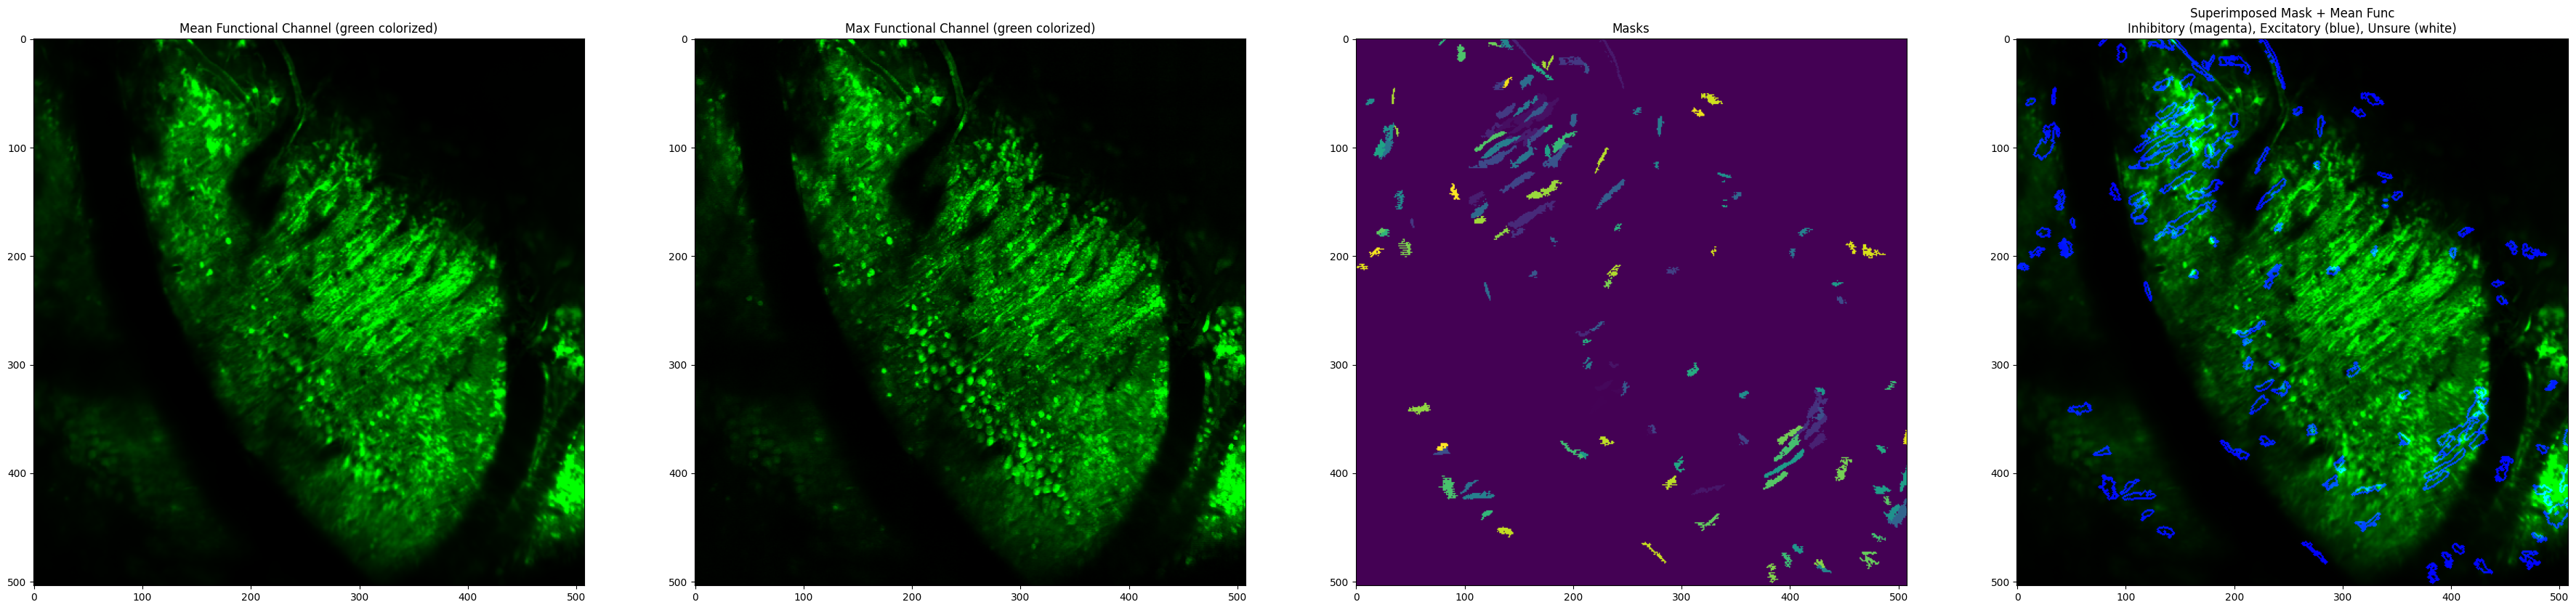

In [11]:
plot_fov_summary(mean_fun_channel, max_fun_channel, masks, superimpose_mask_func, mean_anat, superimpose_mask_anat, save_path=list_ops[0]['save_path0'])

* Read Raw voltage

In [12]:
# read raw_voltages.h5.
def read_raw_voltages(ops):
    mm_path, file_path = get_memmap_path(ops, 'raw_voltages.h5')
    with h5py.File(file_path, 'r') as f:
        vol_time     = create_memmap(f['raw']['vol_time'],     'float32', os.path.join(mm_path, 'vol_time.mmap'))
        vol_start    = create_memmap(f['raw']['vol_start'],    'int8',    os.path.join(mm_path, 'vol_start.mmap'))
        vol_stim_vis = create_memmap(f['raw']['vol_stim_vis'], 'int8',    os.path.join(mm_path, 'vol_stim_vis.mmap'))
        vol_hifi     = create_memmap(f['raw']['vol_hifi'],     'int8',    os.path.join(mm_path, 'vol_hifi.mmap'))
        vol_img      = create_memmap(f['raw']['vol_img'],      'int8',    os.path.join(mm_path, 'vol_img.mmap'))
        vol_stim_aud = create_memmap(f['raw']['vol_stim_aud'], 'float32', os.path.join(mm_path, 'vol_stim_aud.mmap'))
        vol_flir     = create_memmap(f['raw']['vol_flir'],     'int8',    os.path.join(mm_path, 'vol_flir.mmap'))
        vol_pmt      = create_memmap(f['raw']['vol_pmt'],      'int8',    os.path.join(mm_path, 'vol_pmt.mmap'))
        vol_led      = create_memmap(f['raw']['vol_led'],      'int8',    os.path.join(mm_path, 'vol_led.mmap'))
    return [vol_time, vol_start, vol_stim_vis, vol_img,
            vol_hifi, vol_stim_aud, vol_flir,
            vol_pmt, vol_led]

In [13]:
[vol_time, vol_start, vol_stim_vis, vol_img,
            vol_hifi, vol_stim_aud, vol_flir,
            vol_pmt, vol_led] = read_raw_voltages(list_ops[0])

* Read DFF

In [14]:
# read dff traces.
def read_dff(ops):
    mm_path, file_path = get_memmap_path(ops, 'dff.h5')
    with h5py.File(file_path, 'r') as f:
        dff = create_memmap(f['dff'], 'float32', os.path.join(mm_path, 'dff.mmap'))
    return dff

In [15]:
dff = read_dff(list_ops[0])

* Read bpod

In [16]:
import scipy.io as sio
import pandas as pd
# read bpod session data.
def read_bpod_mat_data(ops, session_start_time):
    def _check_keys(d):
        for key in d:
            if isinstance(d[key], sio.matlab.mat_struct):
                d[key] = _todict(d[key])
        return d
    def _todict(matobj):
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, sio.matlab.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d
    def _tolist(ndarray):
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, sio.matlab.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    # labeling every trials for a subject
    def states_labeling(trial_states):
        if 'Punish' in trial_states.keys() and not np.isnan(trial_states['Punish'][0]):
            outcome = 'punish'
        elif 'Reward' in trial_states.keys() and not np.isnan(trial_states['Reward'][0]):
            outcome = 'reward'
        elif 'PunishNaive' in trial_states.keys() and not np.isnan(trial_states['PunishNaive'][0]):
            outcome = 'naive_punish'
        elif 'RewardNaive' in trial_states.keys() and not np.isnan(trial_states['RewardNaive'][0]):
            outcome = 'naive_reward'
        elif 'DidNotChoose' in trial_states.keys() and not np.isnan(trial_states['DidNotChoose'][0]):
            outcome = 'no_choose'
        else:
            outcome = 'other'
        return outcome
    # find state timing.
    def get_state(trial_state_dict, target_state, trial_start):
        if target_state in trial_state_dict:
            time_state = 1000*np.array(trial_state_dict[target_state]) + trial_start
        else:
            time_state = np.array([np.nan, np.nan])
        return time_state
    # read raw data.
    raw = sio.loadmat(
        os.path.join(ops['save_path0'], 'bpod_session_data.mat'),
        struct_as_record=False, squeeze_me=True)
    raw = _check_keys(raw)['SessionData']
    trial_labels = dict()
    n_trials = raw['nTrials']
    trial_states = [raw['RawEvents']['Trial'][ti]['States'] for ti in range(n_trials)]
    trial_events = [raw['RawEvents']['Trial'][ti]['Events'] for ti in range(n_trials)]
    # trial start time stamps.
    trial_labels['time_trial_start'] = 1000*np.array(raw['TrialStartTimestamp']).reshape(-1)
    # trial end time stamps.
    trial_labels['time_trial_end'] = 1000*np.array(raw['TrialEndTimestamp']).reshape(-1)
    # correct timestamps starting from session start.
    trial_labels['time_trial_end'] = trial_labels['time_trial_end'] - trial_labels['time_trial_start'][0] + session_start_time
    trial_labels['time_trial_start'] = trial_labels['time_trial_start'] - trial_labels['time_trial_start'][0] + session_start_time
    # trial target.
    trial_labels['trial_type'] = np.array(raw['TrialTypes']).reshape(-1)-1
    # trial outcomes.
    trial_labels['outcome'] = np.array([states_labeling(ts) for ts in trial_states], dtype='object')
    # trial state timings.
    trial_labels['state_window_choice'] = np.array([
        get_state(trial_states[ti], 'WindowChoice', trial_labels['time_trial_start'][ti])
        for ti in range(n_trials)] + ['yicong_forever'], dtype='object')[:-1]
    trial_labels['state_reward'] = np.array([
        get_state(trial_states[ti], 'Reward', trial_labels['time_trial_start'][ti])
        for ti in range(n_trials)] + ['yicong_forever'], dtype='object')[:-1]
    trial_labels['state_punish'] = np.array([
        get_state(trial_states[ti], 'Punish', trial_labels['time_trial_start'][ti])
        for ti in range(n_trials)] + ['yicong_forever'], dtype='object')[:-1]
    # stimulus timing.
    trial_isi = []
    trial_stim_seq = []
    for ti in range(n_trials):
        # stimulus sequence.
        if ('BNC1High' in trial_events[ti].keys() and
            'BNC1Low' in trial_events[ti].keys() and
            len(np.array(trial_events[ti]['BNC1High']).reshape(-1))==2 and
            len(np.array(trial_events[ti]['BNC1Low']).reshape(-1))==2
            ):
            stim_seq = 1000*np.array([trial_events[ti]['BNC1High'], trial_events[ti]['BNC1Low']]) + trial_labels['time_trial_start'][ti]
            stim_seq = np.transpose(stim_seq, [1,0])
            isi = 1000*np.array(trial_events[ti]['BNC1High'][1] - trial_events[ti]['BNC1Low'][0])
        else:
            stim_seq = np.array([[np.nan, np.nan], [np.nan, np.nan]])
            isi = np.nan
        trial_stim_seq.append(stim_seq)
        trial_isi.append(isi)
    trial_labels['stim_seq'] = np.array(trial_stim_seq + ['yicong_forever'], dtype='object')[:-1]
    trial_labels['isi'] = np.array(trial_isi + ['yicong_forever'], dtype='object')[:-1]
    # licking.
    trial_lick = []
    for ti in range(n_trials):
        licking_events = []
        # 0 left 1 right.
        direction = []
        # 0 wrong 1 correct.
        correctness = []
        # left.
        if 'Port1In' in trial_events[ti].keys():
            lick_left = np.array(trial_events[ti]['Port1In']).reshape(-1)
            licking_events.append(lick_left)
            direction.append(np.zeros_like(lick_left))
            if trial_labels['trial_type'][ti] == 0:
                correctness.append(np.ones_like(lick_left))
            else:
                correctness.append(np.zeros_like(lick_left))
        # right.
        if 'Port3In' in trial_events[ti].keys():
            lick_right = np.array(trial_events[ti]['Port3In']).reshape(-1)
            licking_events.append(lick_right)
            direction.append(np.ones_like(lick_right))
            if trial_labels['trial_type'][ti] == 1:
                correctness.append(np.ones_like(lick_right))
            else:
                correctness.append(np.zeros_like(lick_right))
        if len(licking_events) > 0:
            # combine all licking.
            licking_events = 1000*np.concatenate(licking_events).reshape(1,-1) + trial_labels['time_trial_start'][ti]
            direction = np.concatenate(direction).reshape(1,-1)
            correctness = np.concatenate(correctness).reshape(1,-1)
            lick = np.concatenate([licking_events, direction, correctness], axis=0)
            # sort based on timing.
            lick = lick[:,np.argsort(lick[0,:])]
            # filter false detection before licking window.
            lick = lick[:,lick[0,:] >= trial_labels['state_window_choice'][ti][0]]
            # classify licking.
            if np.size(lick) != 0:
                lick_type = np.full(lick.shape[1], np.nan)
                lick_type[0] = 1
                if (not np.isnan(trial_labels['state_reward'][ti][1]) and
                    len(lick_type) > 1
                    ):
                    lick_type[1:][lick[0,1:] > trial_labels['state_reward'][ti][0]] = 0
                lick_type = lick_type.reshape(1,-1)
                lick = np.concatenate([lick, lick_type], axis=0)
            else:
                lick = np.array([[np.nan], [np.nan], [np.nan], [np.nan]])
        else:
            lick = np.array([[np.nan], [np.nan], [np.nan], [np.nan]])
        # all licking events.
        trial_lick.append(lick)
    trial_labels['lick'] = np.array(trial_lick + ['yicong_forever'], dtype='object')[:-1]
    # convert to dataframe.
    trial_labels = pd.DataFrame(trial_labels)
    return trial_labels

In [17]:
# remove trial start trigger voltage impulse.
def remove_start_impulse(vol_time, vol_stim_vis):
    min_duration = 100
    changes = np.diff(vol_stim_vis.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0] + 1
    if vol_stim_vis[0] == 1:
        start_indices = np.insert(start_indices, 0, 0)
    if vol_stim_vis[-1] == 1:
        end_indices = np.append(end_indices, len(vol_stim_vis))
    for start, end in zip(start_indices, end_indices):
        duration = vol_time[end-1] - vol_time[start]
        if duration < min_duration:
            vol_stim_vis[start:end] = 0
    return vol_stim_vis

# correct beginning vol_stim_vis if not start from 0.
def correct_vol_start(vol_stim_vis):
    if vol_stim_vis[0] == 1:
        vol_stim_vis[:np.where(vol_stim_vis==0)[0][0]] = 0
    return vol_stim_vis

# detect the rising edge and falling edge of binary series.
def get_trigger_time(
        vol_time,
        vol_bin
        ):
    # find the edge with np.diff and correct it by preappend one 0.
    diff_vol = np.diff(vol_bin, prepend=0)
    idx_up = np.where(diff_vol == 1)[0]
    idx_down = np.where(diff_vol == -1)[0]
    # select the indice for risging and falling.
    # give the edges in ms.
    time_up   = vol_time[idx_up]
    time_down = vol_time[idx_down]
    return time_up, time_down

# find when bpod session timer start.
def get_session_start_time(vol_time, vol_start):
    time_up, _ = get_trigger_time(vol_time, vol_start)
    session_start_time = time_up[0]
    return session_start_time

# correct the fluorescence signal timing.
def correct_time_img_center(time_img):
    # find the frame internal.
    diff_time_img = np.diff(time_img, append=0)
    # correct the last element.
    diff_time_img[-1] = np.mean(diff_time_img[:-1])
    # move the image timing to the center of photon integration interval.
    diff_time_img = diff_time_img / 2
    # correct each individual timing.
    time_neuro = time_img + diff_time_img
    return time_neuro

# save trial neural data.
def save_trials(
        ops, time_neuro, dff, trial_labels,
        vol_time, vol_stim_vis,
        vol_stim_aud, vol_flir,
        vol_pmt, vol_led
        ):
    # file structure:
    # ops['save_path0'] / neural_trials.h5
    # ---- time
    # ---- stim
    # ---- dff
    # ---- vol_stim
    # ---- vol_time
    # trial_labels.csv
    h5_path = os.path.join(ops['save_path0'], 'neural_trials.h5')
    if os.path.exists(h5_path):
        os.remove(h5_path)
    f = h5py.File(h5_path, 'w')
    grp = f.create_group('neural_trials')
    grp['time']         = time_neuro
    grp['dff']          = dff
    grp['vol_time']     = vol_time
    grp['vol_stim_vis'] = vol_stim_vis
    grp['vol_stim_aud'] = vol_stim_aud
    grp['vol_flir']     = vol_flir
    grp['vol_pmt']      = vol_pmt
    grp['vol_led']      = vol_led
    f.close()
    trial_labels.to_csv(os.path.join(ops['save_path0'], 'trial_labels.csv'))

In [18]:
print('Reading dff traces and voltage recordings')
# dff = read_dff(list_ops[0])
# [vol_time, vol_start, vol_stim_vis, vol_img,
#     vol_hifi, vol_stim_aud, vol_flir,
#     vol_pmt, vol_led] = read_raw_voltages(list_ops[0])
vol_stim_vis = remove_start_impulse(vol_time, vol_stim_vis)
vol_stim_vis = correct_vol_start(vol_stim_vis)
session_start_time = get_session_start_time(vol_time, vol_start)
trial_labels = read_bpod_mat_data(list_ops[0], session_start_time)
print('Correcting 2p camera trigger time')
# signal trigger time stamps.
time_img, _   = get_trigger_time(vol_time, vol_img)
# correct imaging timing.
time_neuro = correct_time_img_center(time_img)
# save the final data.
print('Saving trial data')
save_trials(
    list_ops[0], time_neuro, dff, trial_labels,
    vol_time, vol_stim_vis,
    vol_stim_aud, vol_flir,
    vol_pmt, vol_led)


Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data


* Reading Trialization

In [19]:
from scipy.signal import savgol_filter

# read trial label csv file into dataframe.
def read_trial_label(ops):
    raw_csv = pd.read_csv(os.path.join(ops['save_path0'], 'trial_labels.csv'), index_col=0)
    # recover object numpy array from csv str.
    def object_parse(k, shape):
        arr = np.array(
            [np.fromstring(s.replace('[', '').replace(']', ''), sep=' ').reshape(shape)
             for s in raw_csv[k].to_list()] + ['yicong_forever'],
            dtype='object')[:-1]
        return arr
    # parse all array.
    time_trial_start = raw_csv['time_trial_start'].to_numpy(dtype='float32')
    time_trial_end = raw_csv['time_trial_end'].to_numpy(dtype='float32')
    trial_type = raw_csv['trial_type'].to_numpy(dtype='int8')
    outcome = raw_csv['outcome'].to_numpy(dtype='object')
    state_window_choice = object_parse('state_window_choice', [-1])
    state_reward = object_parse('state_reward', [-1])
    state_punish = object_parse('state_punish', [-1])
    stim_seq = object_parse('stim_seq', [-1,2])
    isi = raw_csv['isi'].to_numpy(dtype='float32')
    lick = object_parse('lick', [4,-1])
    # convert to dataframe.
    trial_labels = pd.DataFrame({
        'time_trial_start': time_trial_start,
        'time_trial_end': time_trial_end,
        'trial_type': trial_type,
        'outcome': outcome,
        'state_window_choice': state_window_choice,
        'state_reward': state_reward,
        'state_punish': state_punish,
        'stim_seq': stim_seq,
        'isi': isi,
        'lick': lick,
        })
    return trial_labels

# read trailized neural traces with stimulus alignment.
def read_neural_trials(ops, smooth):
    mm_path, file_path = get_memmap_path(ops, 'neural_trials.h5')
    trial_labels = read_trial_label(ops)
    with h5py.File(file_path, 'r') as f:
        neural_trials = dict()
        dff = np.array(f['neural_trials']['dff'])
        if smooth:
            window_length=9
            polyorder=3
            dff = np.apply_along_axis(
                savgol_filter, 1, dff,
                window_length=window_length,
                polyorder=polyorder)
        else: pass
        neural_trials['dff']          = create_memmap(dff,                                'float32', os.path.join(mm_path, 'dff.mmap'))
        neural_trials['time']         = create_memmap(f['neural_trials']['time'],         'float32', os.path.join(mm_path, 'time.mmap'))
        neural_trials['trial_labels'] = trial_labels
        neural_trials['vol_time']     = create_memmap(f['neural_trials']['vol_time'],     'float32', os.path.join(mm_path, 'vol_time.mmap'))
        neural_trials['vol_stim_vis'] = create_memmap(f['neural_trials']['vol_stim_vis'], 'int8',    os.path.join(mm_path, 'vol_stim_vis.mmap'))
        neural_trials['vol_stim_aud'] = create_memmap(f['neural_trials']['vol_stim_aud'], 'float32', os.path.join(mm_path, 'vol_stim_aud.mmap'))
        neural_trials['vol_flir']     = create_memmap(f['neural_trials']['vol_flir'],     'int8',    os.path.join(mm_path, 'vol_flir.mmap'))
        neural_trials['vol_pmt']      = create_memmap(f['neural_trials']['vol_pmt'],      'int8',    os.path.join(mm_path, 'vol_pmt.mmap'))
        neural_trials['vol_led']      = create_memmap(f['neural_trials']['vol_led'],      'int8',    os.path.join(mm_path, 'vol_led.mmap'))
    return neural_trials

In [20]:
neural_trials = read_neural_trials(list_ops[0], 1)
trial_labels = read_trial_label(list_ops[0])

* Align around stim/ reward/ punish/ first lick

In [21]:
from tqdm import tqdm

# cut sequence into the same length as the shortest one given pivots.
def trim_seq(
        data,
        pivots,
        ):
    if len(data[0].shape) == 1:
        len_l_min = np.min(pivots)
        len_r_min = np.min([len(data[i])-pivots[i] for i in range(len(data))])
        data = [data[i][pivots[i]-len_l_min:pivots[i]+len_r_min]
                for i in range(len(data))]
    if len(data[0].shape) == 3:
        len_l_min = np.min(pivots)
        len_r_min = np.min([len(data[i][0,0,:])-pivots[i] for i in range(len(data))])
        data = [data[i][:, :, pivots[i]-len_l_min:pivots[i]+len_r_min]
                for i in range(len(data))]
    return data


def get_lick_response(
    neural_trials,
    l_frames, r_frames
    ):
    # initialization.
    time = neural_trials['time']
    neu_seq    = []
    neu_time   = []
    direction  = []
    correction = []
    lick_type  = []
    # get all licking events.
    lick = np.concatenate(neural_trials['trial_labels']['lick'].to_numpy(), axis=1)
    # loop over licks.
    for li in tqdm(range(lick.shape[1])):
        t = lick[0,li]
        if not np.isnan(t):
            # get state start timing.
            idx = np.searchsorted(neural_trials['time'], t)
            if idx > l_frames and idx < len(neural_trials['time'])-r_frames:
                # signal response.
                f = neural_trials['dff'][:, idx-l_frames : idx+r_frames]
                f = np.expand_dims(f, axis=0)
                neu_seq.append(f)
                # signal time stamps.
                neu_time.append(neural_trials['time'][idx-l_frames : idx+r_frames] - time[idx])
                # licking properties.
                direction.append(lick[1,li])
                correction.append(lick[2,li])
                lick_type.append(lick[3,li])
    # correct neural data centering at zero.
    neu_time_zero = [np.argmin(np.abs(nt)) for nt in neu_time]
    neu_time = trim_seq(neu_time, neu_time_zero)
    neu_seq = trim_seq(neu_seq, neu_time_zero)
    # concatenate results.
    neu_seq    = np.concatenate(neu_seq, axis=0)
    neu_time   = [nt.reshape(1,-1) for nt in neu_time]
    neu_time   = np.concatenate(neu_time, axis=0)
    direction  = np.array(direction)
    correction = np.array(correction)
    lick_type  = np.array(lick_type)
    # get mean time stamps.
    neu_time = np.mean(neu_time, axis=0)
    # combine results.
    return [neu_seq, neu_time, direction, correction, lick_type]

# extract response around stimulus.
def get_perception_response(
        neural_trials, target_state,
        l_frames, r_frames,
        indices = 0
        ):
    exclude_start_trials = 2
    exclude_end_trials = 2
    # initialization.
    time = neural_trials['time']
    neu_seq    = []
    neu_time   = []
    stim_seq   = []
    stim_value = []
    stim_time  = []
    led_value  = []
    trial_type = []
    isi        = []
    decision   = []
    outcome    = []
    # loop over trials.
    for ti in tqdm(range(len(neural_trials['trial_labels']))):
        t = neural_trials['trial_labels'][target_state][ti].flatten()[indices]
        if (not np.isnan(t) and
            ti >= exclude_start_trials and
            ti < len(neural_trials['trial_labels'])-exclude_end_trials
            ):
            # get state start timing.
            idx = np.searchsorted(neural_trials['time'], t)
            if idx > l_frames and idx < len(neural_trials['time'])-r_frames:
                # signal response.
                f = neural_trials['dff'][:, idx-l_frames : idx+r_frames]
                f = np.expand_dims(f, axis=0)
                neu_seq.append(f)
                # signal time stamps.
                neu_time.append(neural_trials['time'][idx-l_frames : idx+r_frames] - time[idx])
                # voltage.
                vol_t_c = np.searchsorted(neural_trials['vol_time'], neural_trials['time'][idx])
                vol_t_l = np.searchsorted(neural_trials['vol_time'], neural_trials['time'][idx-l_frames])
                vol_t_r = np.searchsorted(neural_trials['vol_time'], neural_trials['time'][idx+r_frames])
                stim_time.append(neural_trials['vol_time'][vol_t_l:vol_t_r] - neural_trials['vol_time'][vol_t_c])
                stim_value.append(neural_trials['vol_stim_vis'][vol_t_l:vol_t_r])
                led_value.append(neural_trials['vol_led'][vol_t_l:vol_t_r])
                # task variables.
                stim_seq.append(neural_trials['trial_labels']['stim_seq'][ti].reshape(1,2,2) - t)
                trial_type.append(neural_trials['trial_labels']['trial_type'][ti])
                isi.append(neural_trials['trial_labels']['isi'][ti])
                decision.append(neural_trials['trial_labels']['lick'][ti][1,0])
                outcome.append(neural_trials['trial_labels']['outcome'][ti])
        else: pass
    # correct neural data centering at zero.
    neu_time_zero = [np.argmin(np.abs(nt)) for nt in neu_time]
    neu_time = trim_seq(neu_time, neu_time_zero)
    neu_seq = trim_seq(neu_seq, neu_time_zero)
    # correct voltage data centering at zero.
    stim_time_zero = [np.argmin(np.abs(sv)) for sv in stim_value]
    stim_time = trim_seq(stim_time, stim_time_zero)
    stim_value = trim_seq(stim_value, stim_time_zero)
    led_value = trim_seq(led_value, stim_time_zero)
    # concatenate results.
    neu_seq    = np.concatenate(neu_seq, axis=0)
    neu_time   = [nt.reshape(1,-1) for nt in neu_time]
    neu_time   = np.concatenate(neu_time, axis=0)
    stim_seq   = np.concatenate(stim_seq, axis=0)
    stim_value = [sv.reshape(1,-1) for sv in stim_value]
    stim_value = np.concatenate(stim_value, axis=0)
    stim_time  = [st.reshape(1,-1) for st in stim_time]
    stim_time  = np.concatenate(stim_time, axis=0)
    led_value  = [lv.reshape(1,-1) for lv in led_value]
    led_value  = np.concatenate(led_value, axis=0)
    trial_type = np.array(trial_type)
    isi        = np.array(isi)
    decision   = np.array(decision)
    outcome    = np.array(outcome)
    # get mean time stamps.
    neu_time  = np.mean(neu_time, axis=0)
    stim_time = np.mean(stim_time, axis=0)
    # combine results.
    return [neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome]


# Analysis figure

100%|██████████| 2811/2811 [00:00<00:00, 11904.28it/s]


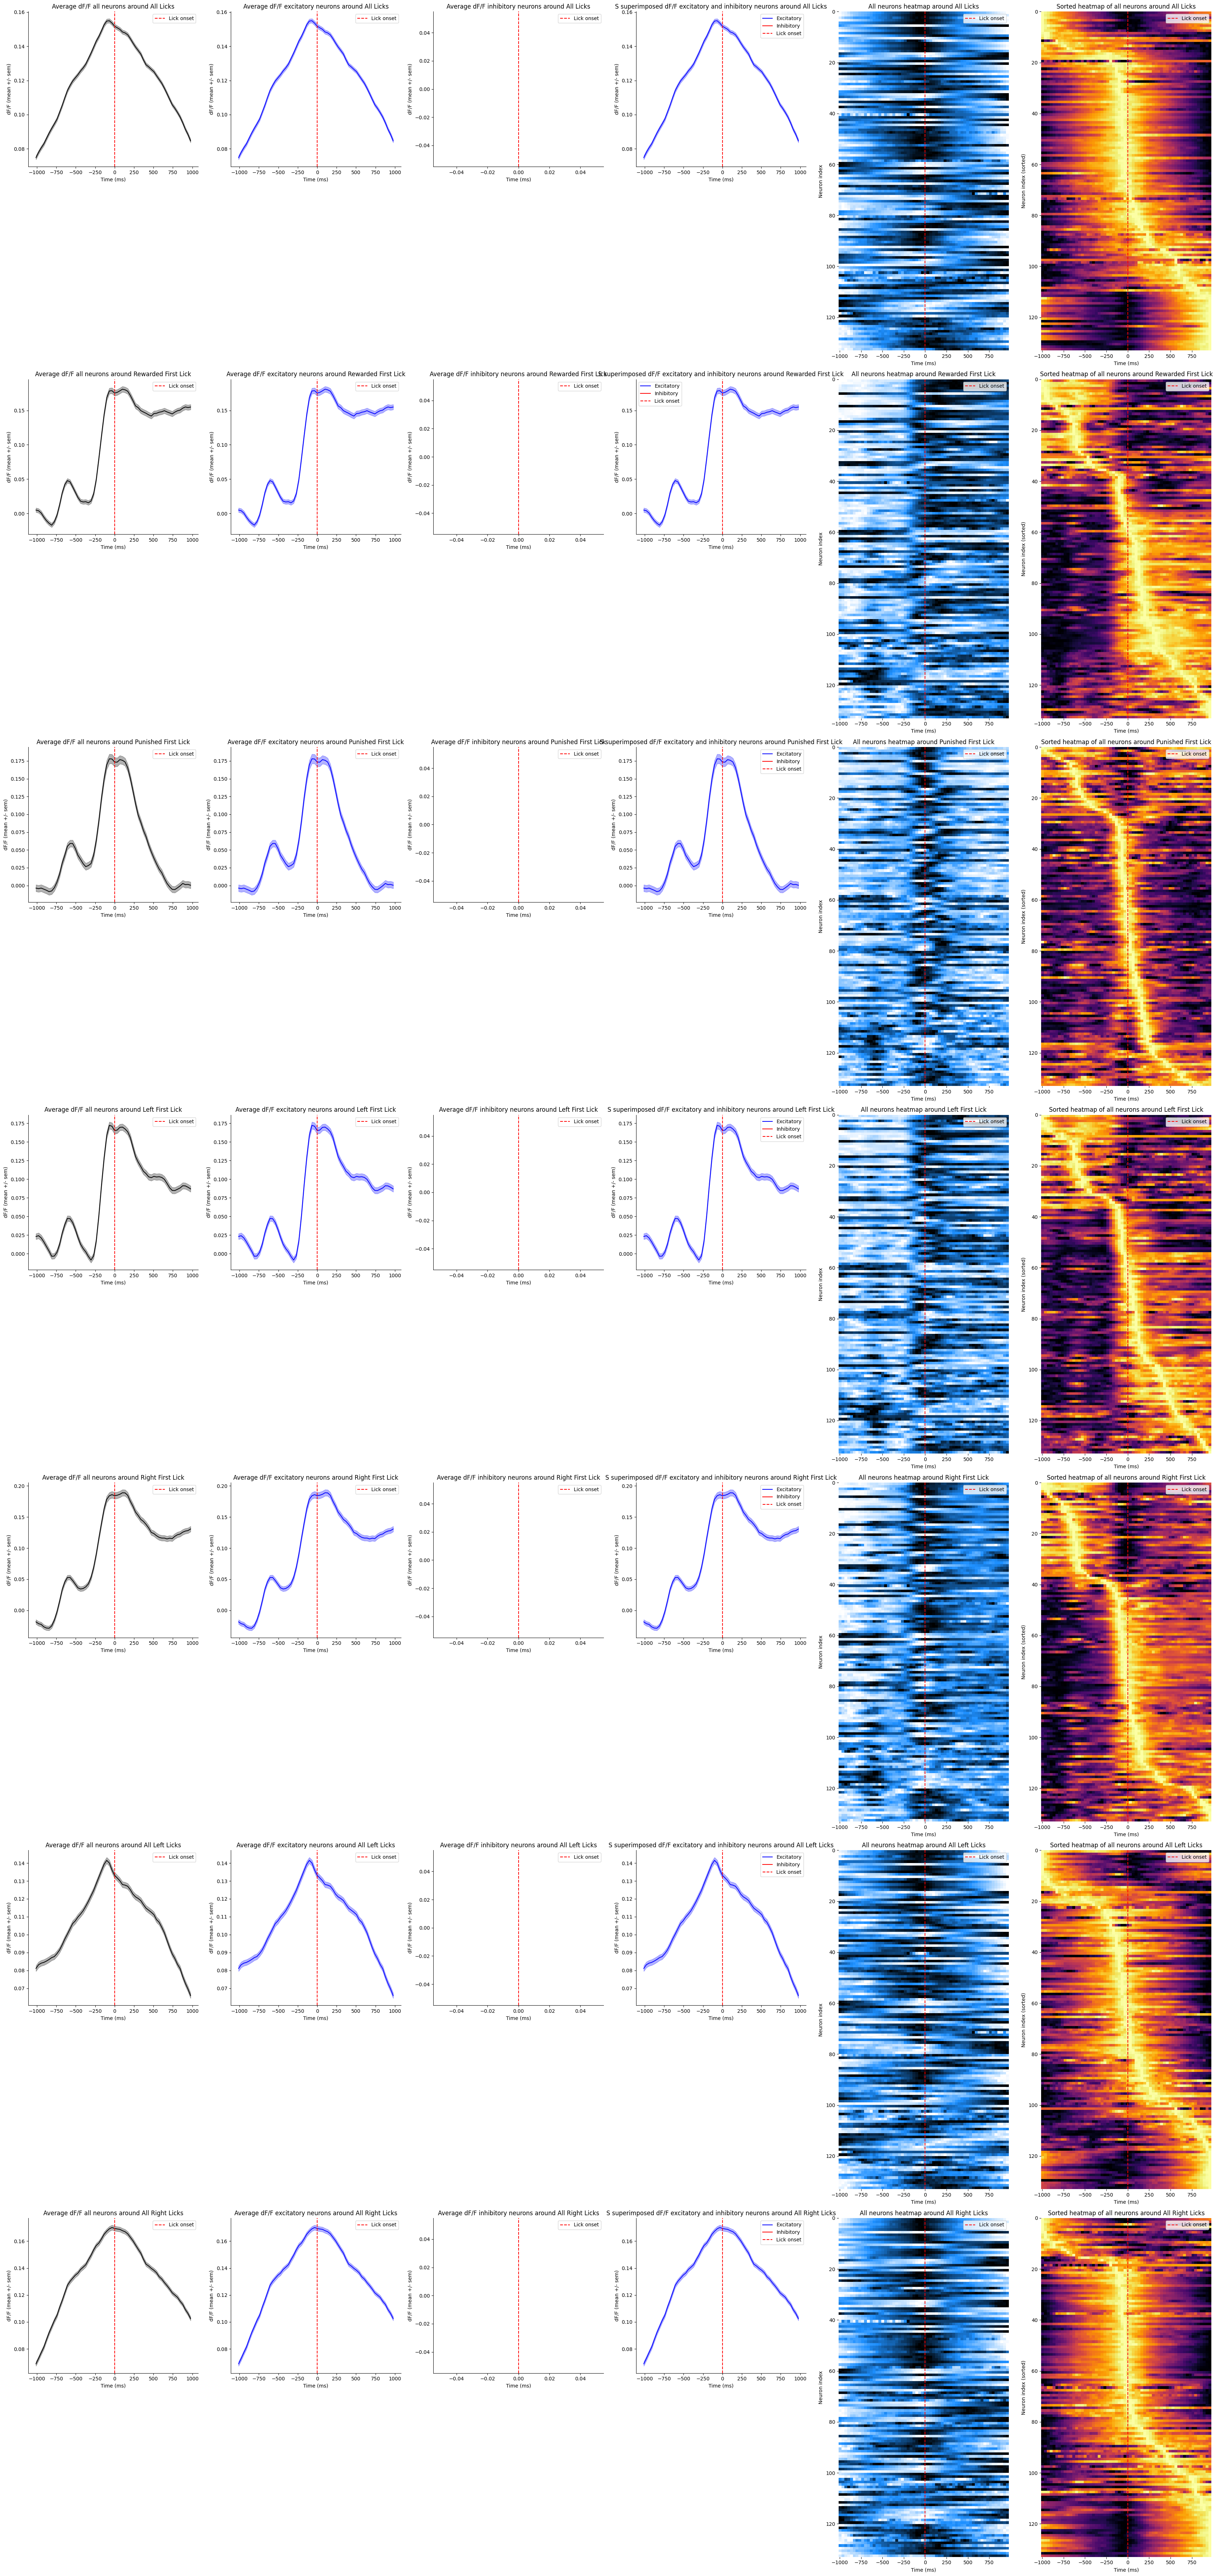

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import numpy as np
from scipy.stats import sem
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings("ignore")

def get_roi_label_color(labels, roi_id):
    """
    Get category, colors, and colormap based on neuron label.
    
    Parameters:
    labels (np.ndarray): Array of neuron labels (-1 for excitatory, 0 for unsure, 1 for inhibitory).
    roi_id (int): Index of the neuron.
    
    Returns:
    tuple: (category, color1, color2, cmap)
    """
    if labels[roi_id] == -1:
        cate = 'excitatory'
        color1 = 'grey'
        color2 = 'dodgerblue'
        cmap = LinearSegmentedColormap.from_list('excitatory_cmap', ['white', 'dodgerblue', 'black'])
    elif labels[roi_id] == 0:
        cate = 'unsure'
        color1 = 'grey'
        color2 = 'mediumseagreen'
        cmap = LinearSegmentedColormap.from_list('unsure_cmap', ['white', 'mediumseagreen', 'black'])
    elif labels[roi_id] == 1:
        cate = 'inhibitory'
        color1 = 'grey'
        color2 = 'hotpink'
        cmap = LinearSegmentedColormap.from_list('inhibitory_cmap', ['white', 'hotpink', 'black'])
    return cate, color1, color2, cmap

def apply_colormap(data, cmap):
    """Normalize data and apply colormap."""
    if len(data) > 0:
        vmin, vmax = data.min(), data.max()
        normalized = (data - vmin) / (vmax - vmin + 1e-10)
        return cmap(normalized)
    return np.array([])

def adjust_layout_heatmap(ax):
    """Adjust heatmap layout by removing spines."""
    for spine in ax.spines.values():
        spine.set_visible(False)

def plot_gridspec_subplot(fig, gs, position, time, avg_data, sem_data, title, color='black'):
    """Create a subplot with mean, SEM shading, and custom styling."""
    ax = fig.add_subplot(gs[position])
    ax.plot(time, avg_data, color=color)
    ax.fill_between(time, avg_data - sem_data, avg_data + sem_data, color=color, alpha=0.3)
    ax.axvline(0, color='red', linestyle='--', label='Lick onset')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('dF/F (mean +/- sem)')
    ax.set_title(title)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_gridspec_superimposed(fig, gs, position, time, avg_data1, sem_data1, label1, color1, 
                             avg_data2, sem_data2, label2, color2, title):
    """Create a subplot with two superimposed traces."""
    ax = fig.add_subplot(gs[position])
    ax.plot(time, avg_data1, color=color1, label=label1)
    ax.fill_between(time, avg_data1 - sem_data1, avg_data1 + sem_data1, color=color1, alpha=0.3)
    ax.plot(time, avg_data2, color=color2, label=label2)
    ax.fill_between(time, avg_data2 - sem_data2, avg_data2 + sem_data2, color=color2, alpha=0.3)
    ax.axvline(0, color='red', linestyle='--', label='Lick onset')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('dF/F (mean +/- sem)')
    ax.set_title(title)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_gridspec_heatmap(fig, gs, position, time, data, labels, title, vmin=None, vmax=None):
    """Create a heatmap subplot with label-specific colormaps."""
    ax = fig.add_subplot(gs[position])
    n_neurons, time_window = data.shape
    heatmap_rgb = np.zeros((n_neurons, time_window, 4))
    
    for i in range(n_neurons):
        _, _, _, cmap = get_roi_label_color(labels, i)
        heatmap_rgb[i] = apply_colormap(data[i], cmap)
    
    im = ax.imshow(heatmap_rgb, interpolation='nearest', aspect='auto',
                   extent=[time[0], time[-1], n_neurons, 0])
    ax.axvline(0, color='red', linestyle='--', label='Lick onset')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron index')
    ax.set_title(title)
    ax.legend()
    adjust_layout_heatmap(ax)
    # fig.colorbar(im, ax=ax, label='dF/F')
    return ax

def plot_sorted_heatmap(fig, gs, position, time, data, labels, title, vmin=None, vmax=None, 
                       sort_interval=None):
    """Plot sorted heatmap using inferno colormap."""
    ax = fig.add_subplot(gs[position])
    n_neurons, time_window = data.shape

    if sort_interval is not None:
        start_t, end_t = sort_interval
        sort_mask = (time >= start_t) & (time <= end_t)
        sort_time = time[sort_mask]
        data_for_sorting = data[:, sort_mask]
        peak_indices = np.argmax(data_for_sorting, axis=1)
        peak_times = sort_time[peak_indices]
    else:
        peak_indices = np.argmax(data, axis=1)
        peak_times = time[peak_indices]

    sorted_indices = np.argsort(peak_times)
    sorted_data = data[sorted_indices]
    cmap = cm.get_cmap('inferno')
    heatmap_rgb = np.array([apply_colormap(row, cmap) for row in sorted_data])

    im = ax.imshow(heatmap_rgb, interpolation='nearest', aspect='auto',
                   extent=[time[0], time[-1], n_neurons, 0])
    ax.axvline(0, color='red', linestyle='--', label='Lick onset')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron index (sorted)')
    ax.set_title(title)
    if ax.get_legend_handles_labels()[0]:
        ax.legend()
    adjust_layout_heatmap(ax)
    # fig.colorbar(im, ax=ax, label='dF/F')
    return ax

def calculate_metrics(neu_seq, filter_licks, labels=None):
    """Calculate average, SEM, and heatmap data for given filter."""
    if labels is None:
        avg = np.nanmean(neu_seq[filter_licks, :, :], axis=(0, 1))
        sem_data = sem(neu_seq[filter_licks, :, :], axis=(0, 1), nan_policy='omit')
        heat = np.nanmean(neu_seq[filter_licks, :, :], axis=0)
        return avg, sem_data, heat
    else:
        avg_all = np.nanmean(neu_seq[filter_licks, :, :], axis=(0, 1))
        sem_all = sem(neu_seq[filter_licks, :, :], axis=(0, 1), nan_policy='omit')
        avg_ex = np.nanmean(neu_seq[filter_licks][:, labels == -1, :], axis=(0, 1))
        sem_ex = sem(neu_seq[filter_licks][:, labels == -1, :], axis=(0, 1), nan_policy='omit')
        avg_inh = np.nanmean(neu_seq[filter_licks][:, labels == 1, :], axis=(0, 1))
        sem_inh = sem(neu_seq[filter_licks][:, labels == 1, :], axis=(0, 1), nan_policy='omit')
        heat = np.nanmean(neu_seq[filter_licks, :, :], axis=0)
        return avg_all, sem_all, avg_ex, sem_ex, avg_inh, sem_inh, heat

def set_uniform_ylim(axes_list):
    """Set uniform y-axis limits across related subplots."""
    ylims = [ax.get_ylim() for ax in axes_list]
    ymin = min(ylim[0] for ylim in ylims)
    ymax = max(ylim[1] for ylim in ylims)
    for ax in axes_list:
        ax.set_ylim(ymin, ymax)

def main(neu_seq, neu_time, direction, correction, lick_type, labels):
    """
    Main function to generate neural activity plots.
    
    Parameters:
    neu_seq (np.ndarray): Neural sequence data
    neu_time (np.ndarray): Time array
    direction (np.ndarray): Direction array (0 for left, 1 for right)
    correction (np.ndarray): Correction array (0 for wrong, 1 for correct)
    lick_type (np.ndarray): Lick type array (1 for first lick, 0 for later)
    labels (np.ndarray): Neuron labels (-1 for excitatory, 0 for unsure, 1 for inhibitory)
    """
    # Calculate metrics for different conditions
    conditions = [
        ('All Licks', np.ones_like(direction, dtype=bool)),
        ('Rewarded First Lick', (lick_type == 1) & (correction == 1)),
        ('Punished First Lick', (lick_type == 1) & (correction == 0)),
        ('Left First Lick', (lick_type == 1) & (direction == 0)),
        ('Right First Lick', (lick_type == 1) & (direction == 1)),
        ('All Left Licks', (direction == 0)),
        ('All Right Licks', (direction == 1))
    ]
    
    metrics = {}
    for name, filter_licks in conditions:
        metrics[name] = calculate_metrics(neu_seq, filter_licks, labels)
    
    # Create figure and GridSpec
    fig = plt.figure(figsize=(34, 72))
    gs = gridspec.GridSpec(14, 6)
    
    # Plotting
    axes_groups = []
    for idx, (name, (avg_all, sem_all, avg_ex, sem_ex, avg_inh, sem_inh, heat)) in enumerate(metrics.items()):
        row = idx * 2
        # Plot individual subplots
        ax1 = plot_gridspec_subplot(
            fig, gs, (row, 0), neu_time, avg_all, sem_all,
            title=f'Average dF/F all neurons around {name}', color='black'
        )
        ax2 = plot_gridspec_subplot(
            fig, gs, (row, 1), neu_time, avg_ex, sem_ex,
            title=f'Average dF/F excitatory neurons around {name}', color='blue'
        )
        ax3 = plot_gridspec_subplot(
            fig, gs, (row, 2), neu_time, avg_inh, sem_inh,
            title=f'Average dF/F inhibitory neurons around {name}', color='red'
        )
        ax4 = plot_gridspec_superimposed(
            fig, gs, (row, 3), neu_time,
            avg_ex, sem_ex, 'Excitatory', 'blue',
            avg_inh, sem_inh, 'Inhibitory', 'red',
            title=f'S superimposed dF/F excitatory and inhibitory neurons around {name}'
        )
        ax5 = plot_gridspec_heatmap(
            fig, gs, (slice(row, row+2), 4), neu_time, heat,
            title=f'All neurons heatmap around {name}', labels=labels
        )
        ax6 = plot_sorted_heatmap(
            fig, gs, (slice(row, row+2), 5), neu_time, heat,
            labels, title=f'Sorted heatmap of all neurons around {name}'
        )
        axes_groups.append([ax1, ax2, ax3, ax4])
    
    # Set uniform y-axis limits for related subplots
    # Uncomment the following lines if you want to set uniform y-limits for each group of axes
    # for axes in axes_groups:
    #     set_uniform_ylim(axes)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example usage
    l_frames = 30
    r_frames = 30
    neu_seq, neu_time, direction, correction, lick_type = get_lick_response(neural_trials, l_frames, r_frames)
    main(neu_seq, neu_time, direction, correction, lick_type, labels)

* Stim 

100%|██████████| 402/402 [00:00<00:00, 4428.24it/s]


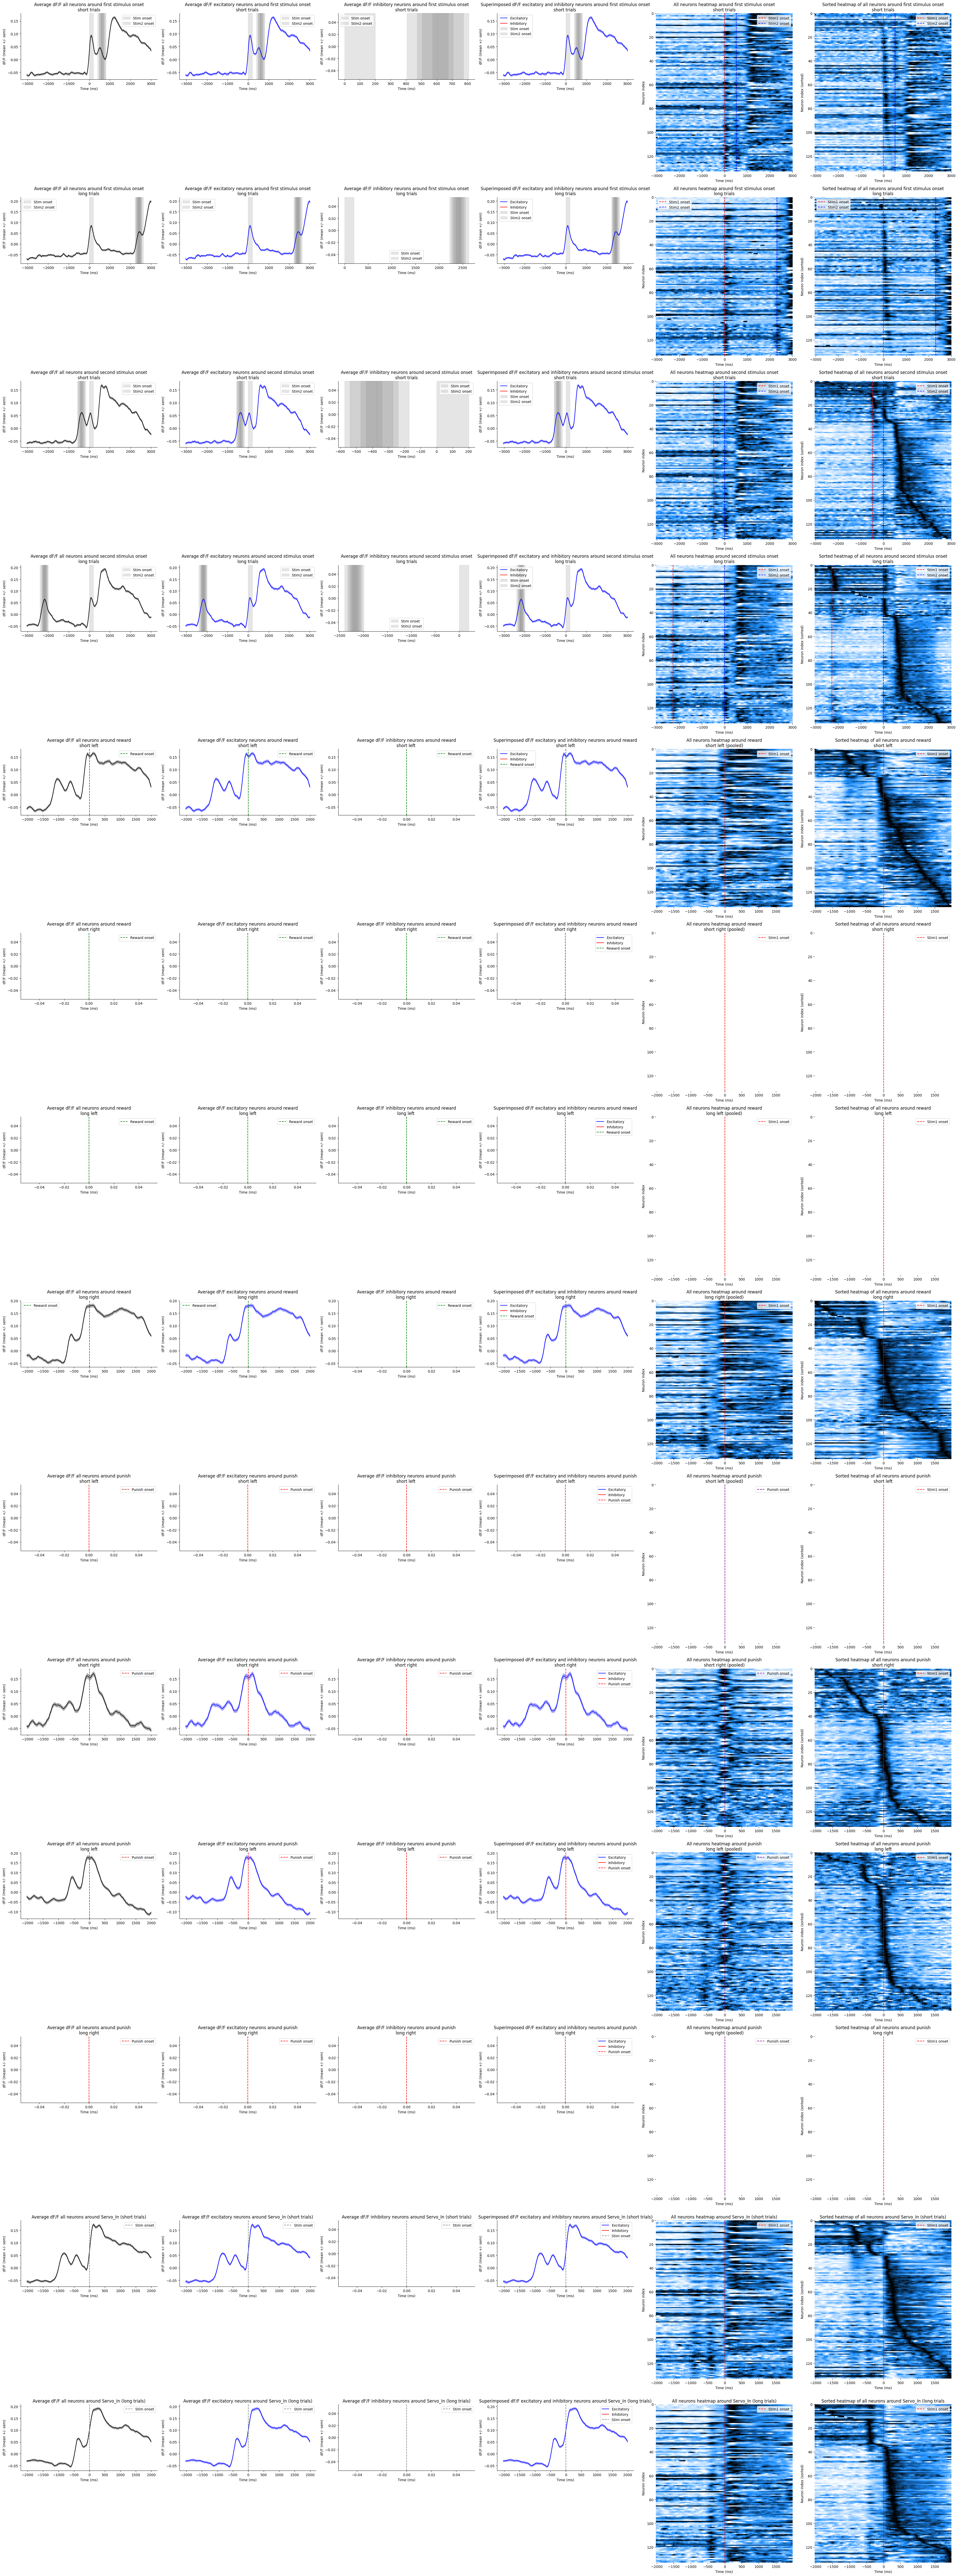

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore")

def get_roi_label_color(labels, roi_id):
    """Get category, colors, and colormap based on neuron label."""
    colormap_dict = {
        -1: ('excitatory', 'grey', 'dodgerblue', 
             LinearSegmentedColormap.from_list('excitatory_cmap', ['white', 'dodgerblue', 'black'])),
        0: ('unsure', 'grey', 'mediumseagreen', 
            LinearSegmentedColormap.from_list('unsure_cmap', ['white', 'mediumseagreen', 'black'])),
        1: ('inhibitory', 'grey', 'hotpink', 
            LinearSegmentedColormap.from_list('inhibitory_cmap', ['white', 'hotpink', 'black']))
    }
    return colormap_dict.get(labels[roi_id], ('unsure', 'grey', 'mediumseagreen', 
                                             LinearSegmentedColormap.from_list('unsure_cmap', ['white', 'mediumseagreen', 'black'])))

def apply_colormap(data, cmap):
    """Normalize data and apply colormap."""
    if data.size > 0:
        vmin, vmax = np.nanmin(data), np.nanmax(data)
        normalized = (data - vmin) / (vmax - vmin + 1e-10)
        return cmap(normalized)
    return np.array([])

def adjust_layout_heatmap(ax):
    """Adjust heatmap layout by removing spines."""
    for spine in ax.spines.values():
        spine.set_visible(False)

def plot_gridspec_subplot(fig, gs, position, time, avg_data, sem_data, title, color='black', 
                        stim1_time=0, stim2_time=None, line_mode='all', stim_style='bar'):
    """Create a subplot with mean, SEM shading, and stimulus onset markers."""
    ax = fig.add_subplot(gs[position])
    ax.plot(time, avg_data, color=color)
    ax.fill_between(time, avg_data - sem_data, avg_data + sem_data, color=color, alpha=0.3)
    
    stim1_time = [float(stim1_time)] if isinstance(stim1_time, (int, float)) else stim1_time
    stim2_time = [float(stim2_time)] if isinstance(stim2_time, (int, float)) else stim2_time if stim2_time is not None else []
    
    if line_mode in ['all', 'reward', 'punish']:
        colors = {'all': 'gray', 'reward': 'green', 'punish': 'red'}
        color = colors[line_mode]
        label_prefix = {'all': 'Stim', 'reward': 'Reward', 'punish': 'Punish'}
        
        for i, t in enumerate(stim1_time):
            if t is not None and not np.isnan(t):
                label = f'{label_prefix[line_mode]} onset' if i == 0 else None
                if stim_style == 'bar':
                    ax.axvspan(t, t + 200, color=color, alpha=0.2, label=label)
                elif stim_style == 'line':
                    ax.axvline(t, color=color, linestyle='--', label=label)
        if line_mode == 'all':
            for i, t in enumerate(stim2_time):
                if t is not None and not np.isnan(t):
                    label = 'Stim2 onset' if i == 0 else None
                    if stim_style == 'bar':
                        ax.axvspan(t, t + 200, color=color, alpha=0.2, label=label)
                    elif stim_style == 'line':
                        ax.axvline(t, color=color, linestyle='--', label=label)
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('dF/F (mean +/- sem)')
    ax.set_title(title)
    if ax.get_legend_handles_labels()[0]:
        ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_gridspec_superimposed(fig, gs, position, time, avg_data1, sem_data1, label1, color1, 
                             avg_data2, sem_data2, label2, color2, title, 
                             stim1_time=0, stim2_time=None, line_mode='all', stim_style='bar'):
    """Create a subplot with two superimposed traces."""
    ax = fig.add_subplot(gs[position])
    ax.plot(time, avg_data1, color=color1, label=label1)
    ax.fill_between(time, avg_data1 - sem_data1, avg_data1 + sem_data1, color=color1, alpha=0.3)
    ax.plot(time, avg_data2, color=color2, label=label2)
    ax.fill_between(time, avg_data2 - sem_data2, avg_data2 + sem_data2, color=color2, alpha=0.3)
    
    stim1_time = [float(stim1_time)] if isinstance(stim1_time, (int, float)) else stim1_time
    stim2_time = [float(stim2_time)] if isinstance(stim2_time, (int, float)) else stim2_time if stim2_time is not None else []
    
    if line_mode in ['all', 'reward', 'punish']:
        colors = {'all': 'gray', 'reward': 'green', 'punish': 'red'}
        color = colors[line_mode]
        label_prefix = {'all': 'Stim', 'reward': 'Reward', 'punish': 'Punish'}
        
        for i, t in enumerate(stim1_time):
            if t is not None and not np.isnan(t):
                label = f'{label_prefix[line_mode]} onset' if i == 0 else None
                if stim_style == 'bar':
                    ax.axvspan(t, t + 200, color=color, alpha=0.2, label=label)
                elif stim_style == 'line':
                    ax.axvline(t, color=color, linestyle='--', label=label)
        if line_mode == 'all':
            for i, t in enumerate(stim2_time):
                if t is not None and not np.isnan(t):
                    label = 'Stim2 onset' if i == 0 else None
                    if stim_style == 'bar':
                        ax.axvspan(t, t + 200, color=color, alpha=0.2, label=label)
                    elif stim_style == 'line':
                        ax.axvline(t, color=color, linestyle='--', label=label)
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('dF/F (mean +/- sem)')
    ax.set_title(title)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_gridspec_heatmap(fig, gs, position, time, data, labels, title, vmin=None, vmax=None, 
                         stim1_time=0, stim2_time=np.nan, line_mode='all'):
    """Create a heatmap subplot with label-specific colormaps."""
    ax = fig.add_subplot(gs[position])
    n_neurons, time_window = data.shape
    heatmap_rgb = np.zeros((n_neurons, time_window, 4))
    
    unique_labels = np.unique(labels)
    cmap_cache = {label: get_roi_label_color(labels, np.where(labels == label)[0][0])[3] for label in unique_labels}
    
    for i in range(n_neurons):
        heatmap_rgb[i] = apply_colormap(data[i], cmap_cache[labels[i]])
    
    im = ax.imshow(heatmap_rgb, interpolation='nearest', aspect='auto', extent=[time[0], time[-1], n_neurons, 0])
    
    if line_mode in ['all', 'reward', 'punish']:
        colors = {'all': 'red', 'reward': 'red', 'punish': 'purple'}
        labels_dict = {'all': 'Stim1 onset', 'reward': 'Stim1 onset', 'punish': 'Punish onset'}
        if not np.isnan(stim1_time):
            ax.axvline(stim1_time, color=colors[line_mode], linestyle='--', label=labels_dict[line_mode])
        if line_mode == 'all' and not np.isnan(stim2_time):
            ax.axvline(stim2_time, color='blue', linestyle='--', label='Stim2 onset')
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron index')
    ax.set_title(title)
    if ax.get_legend_handles_labels()[0]:
        ax.legend()
    adjust_layout_heatmap(ax)
    # fig.colorbar(im, ax=ax, label='dF/F')
    return ax

def plot_sorted_heatmap(fig, gs, position, time, data, labels, title, vmin=None, vmax=None, 
                       stim1_time=0, stim2_time=np.nan, line_mode='all', sort_interval=None):
    """Plot sorted heatmap with label-specific colormaps."""
    ax = fig.add_subplot(gs[position])
    n_neurons, time_window = data.shape

    if sort_interval is not None:
        start_t, end_t = sort_interval
        sort_mask = (time >= start_t) & (time <= end_t)
        sort_time = time[sort_mask]
        data_for_sorting = data[:, sort_mask]
        peak_indices = np.argmax(data_for_sorting, axis=1)
        peak_times = sort_time[peak_indices]
    else:
        peak_indices = np.argmax(data, axis=1)
        peak_times = time[peak_indices]

    sorted_indices = np.argsort(peak_times)
    sorted_data = data[sorted_indices]
    sorted_labels = labels[sorted_indices]

    heatmap_rgb = np.zeros((n_neurons, time_window, 4))
    unique_labels = np.unique(labels)
    cmap_cache = {label: get_roi_label_color(labels, np.where(labels == label)[0][0])[3] for label in unique_labels}

    for i in range(n_neurons):
        heatmap_rgb[i] = apply_colormap(sorted_data[i], cmap_cache[sorted_labels[i]])

    im = ax.imshow(heatmap_rgb, interpolation='nearest', aspect='auto', extent=[time[0], time[-1], n_neurons, 0])

    if line_mode in ['all', 'reward', 'punish']:
        colors = {'all': 'red', 'reward': 'red', 'punish': 'purple'}
        labels_dict = {'all': 'Stim1 onset', 'reward': 'Stim1 onset', 'punish': 'Punish onset'}
        if not np.isnan(stim1_time):
            ax.axvline(stim1_time, color=colors[line_mode], linestyle='--', label=labels_dict[line_mode])
        if line_mode == 'all' and not np.isnan(stim2_time):
            ax.axvline(stim2_time, color='blue', linestyle='--', label='Stim2 onset')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron index (sorted)')
    ax.set_title(title)
    if ax.get_legend_handles_labels()[0]:
        ax.legend()
    adjust_layout_heatmap(ax)
    # fig.colorbar(im, ax=ax, label='dF/F')
    return ax

def compute_trial_masks(trial_type, decision):
    """Compute masks for different trial types and decisions."""
    return {
        'short_left': (trial_type == 0) & (decision == 0),
        'short_right': (trial_type == 0) & (decision == 1),
        'long_left': (trial_type == 1) & (decision == 0),
        'long_right': (trial_type == 1) & (decision == 1)
    }

def calculate_metrics(neu_seq, mask, labels):
    """Calculate average, SEM, and heatmap data for given mask."""
    exc_mask = labels == -1
    inh_mask = labels == 1
    return {
        'avg_all': np.nanmean(neu_seq[mask], axis=(0, 1)),
        'sem_all': sem(neu_seq[mask], axis=(0, 1), nan_policy='omit'),
        'avg_exc': np.nanmean(neu_seq[mask][:, exc_mask,:], axis=(0, 1)),
        'sem_exc': sem(neu_seq[mask][:, exc_mask, :], axis=(0, 1), nan_policy='omit'),
        'avg_inh': np.nanmean(neu_seq[mask][:, inh_mask, :], axis=(0, 1)),
        'sem_inh': sem(neu_seq[mask][:, inh_mask, :], axis=(0, 1), nan_policy='omit'),
        'heat': np.nanmean(neu_seq[mask], axis=0)
    }

def set_uniform_ylim(axes_list):
    """Set uniform y-axis limits across related subplots."""
    ylims = [ax.get_ylim() for ax in axes_list]
    ymin = min(ylim[0] for ylim in ylims)
    ymax = max(ylim[1] for ylim in ylims)
    for ax in axes_list:
        ax.set_ylim(ymin, ymax)

def pool_session_data(neural_trials_list, labels_list, state, l_frames, r_frames, indices):
    """
    Pool data from multiple sessions.
    
    Returns:
    tuple: Pooled neu_seq (n_trials_total, n_neurons_total, time), neu_time, trial_type, isi, decision, labels
    """
    neu_seqs = []
    trial_types = []
    isis = []
    decisions = []
    all_labels = []

    neuron_counts = [labels.shape[0] for labels in labels_list]
    total_neurons = sum(neuron_counts)

    neuron_offset = 0  # for assigning each session's neurons into the correct padded space

    for i, (neural_trials, session_labels) in enumerate(zip(neural_trials_list, labels_list)):
        neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = get_perception_response(
            neural_trials, state, l_frames, r_frames, indices=indices)

        n_trials, n_neurons, n_time = neu_seq.shape
        padded_neu_seq = np.zeros((n_trials, total_neurons, n_time))

        # Place this session’s neurons in the correct slice
        padded_neu_seq[:, neuron_offset:neuron_offset + n_neurons, :] = neu_seq
        neu_seqs.append(padded_neu_seq)

        trial_types.append(trial_type)
        isis.append(isi)
        decisions.append(decision)
        all_labels.append(session_labels)

        neuron_offset += n_neurons

    # Concatenate along trials
    pooled_neu_seq = np.concatenate(neu_seqs, axis=0)  # (total_trials, total_neurons, time)
    pooled_trial_type = np.concatenate(trial_types, axis=0)
    pooled_isi = np.concatenate(isis, axis=0)
    pooled_decision = np.concatenate(decisions, axis=0)
    pooled_labels = np.concatenate(all_labels, axis=0)

    return pooled_neu_seq, neu_time, pooled_trial_type, pooled_isi, pooled_decision, pooled_labels

def main(neural_trials_list, labels_list):
    """
    Main function to generate neural response plots for pooled session data.
    
    Parameters:
    neural_trials_list (list): List of neural_trials for each session
    labels_list (list): List of neuron labels for each session (-1 for excitatory, 0 for unsure, 1 for inhibitory)
    """
    fig = plt.figure(figsize=(38, 102))
    gs = gridspec.GridSpec(28, 6)
    
    # First stimulus onset
    l_frames, r_frames = 90, 90
    neu_seq, neu_time, trial_type, isi, decision, labels = pool_session_data(
        neural_trials_list, labels_list, 'stim_seq', l_frames, r_frames, indices=0)
    
    short_trials = trial_type == 0
    long_trials = trial_type == 1
    
    metrics_short = calculate_metrics(neu_seq, short_trials, labels)
    metrics_long = calculate_metrics(neu_seq, long_trials, labels)
    
    sec_stim_short = np.unique(isi[short_trials]) + 200
    sec_stim_time_short = np.unique(neu_time[np.searchsorted(neu_time, sec_stim_short)])
    sec_stim_long = np.unique(isi[long_trials]) + 200
    sec_stim_time_long = np.unique(neu_time[np.searchsorted(neu_time, sec_stim_long)])
    
    axes_group1 = [
        plot_gridspec_subplot(fig, gs, (0, 0), neu_time, metrics_short['avg_all'], metrics_short['sem_all'],
                            title='Average dF/F all neurons around first stimulus onset\nshort trials', color='black',
                            stim1_time=0, stim2_time=sec_stim_time_short, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (0, 1), neu_time, metrics_short['avg_exc'], metrics_short['sem_exc'],
                            title='Average dF/F excitatory neurons around first stimulus onset\nshort trials ', color='blue',
                            stim1_time=0, stim2_time=sec_stim_time_short, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (0, 2), neu_time, metrics_short['avg_inh'], metrics_short['sem_inh'],
                            title='Average dF/F inhibitory neurons around first stimulus onset\nshort trials', color='red',
                            stim1_time=0, stim2_time=sec_stim_time_short, line_mode='all'),
        plot_gridspec_superimposed(fig, gs, (0, 3), neu_time,
                                 metrics_short['avg_exc'], metrics_short['sem_exc'], 'Excitatory', 'blue',
                                 metrics_short['avg_inh'], metrics_short['sem_inh'], 'Inhibitory', 'red',
                                 title='Superimposed dF/F excitatory and inhibitory neurons around first stimulus onset\nshort trials ',
                                 stim1_time=0, stim2_time=sec_stim_time_short, line_mode='all')
    ]
    plot_gridspec_heatmap(fig, gs, (slice(0,2), 4), neu_time, metrics_short['heat'],
                         title='All neurons heatmap around first stimulus onset\nshort trials',
                         labels=labels, stim1_time=0, stim2_time=np.nanmean(sec_stim_time_short), line_mode='all')
    plot_sorted_heatmap(fig, gs, (slice(0,2), 5), neu_time, metrics_short['heat'], labels=labels,
                       title='Sorted heatmap of all neurons around first stimulus onset\nshort trials',
                       stim1_time=0, stim2_time=np.nanmean(sec_stim_time_short), line_mode='all', sort_interval=(-400, 400))
    
    axes_group2 = [
        plot_gridspec_subplot(fig, gs, (2, 0), neu_time, metrics_long['avg_all'], metrics_long['sem_all'],
                            title='Average dF/F all neurons around first stimulus onset\nlong trials', color='black',
                            stim1_time=0, stim2_time=sec_stim_time_long, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (2, 1), neu_time, metrics_long['avg_exc'], metrics_long['sem_exc'],
                            title='Average dF/F excitatory neurons around first stimulus onset\nlong trials', color='blue',
                            stim1_time=0, stim2_time=sec_stim_time_long, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (2, 2), neu_time, metrics_long['avg_inh'], metrics_long['sem_inh'],
                            title='Average dF/F inhibitory neurons around first stimulus onset\nlong trials', color='red',
                            stim1_time=0, stim2_time=sec_stim_time_long, line_mode='all'),
        plot_gridspec_superimposed(fig, gs, (2, 3), neu_time,
                                 metrics_long['avg_exc'], metrics_long['sem_exc'], 'Excitatory', 'blue',
                                 metrics_long['avg_inh'], metrics_long['sem_inh'], 'Inhibitory', 'red',
                                 title='Superimposed dF/F excitatory and inhibitory neurons around first stimulus onset\nlong trials',
                                 stim1_time=0, stim2_time=sec_stim_time_long, line_mode='all')
    ]
    plot_gridspec_heatmap(fig, gs, (slice(2,4), 4), neu_time, metrics_long['heat'],
                         title='All neurons heatmap around first stimulus onset\nlong trials',
                         labels=labels, stim1_time=0, stim2_time=np.nanmean(sec_stim_time_long), line_mode='all')
    plot_sorted_heatmap(fig, gs, (slice(2,4), 5), neu_time, metrics_long['heat'], labels=labels,
                       title='Sorted heatmap of all neurons around first stimulus onset\nlong trials',
                       stim1_time=0, stim2_time=np.nanmean(sec_stim_time_long), line_mode='all', sort_interval=(-400, 400))
    
    # Second stimulus onset
    neu_seq, neu_time, trial_type, isi, decision, labels = pool_session_data(
        neural_trials_list, labels_list, 'stim_seq', l_frames, r_frames, indices=2)
    
    metrics_short = calculate_metrics(neu_seq, short_trials, labels)
    metrics_long = calculate_metrics(neu_seq, long_trials, labels)
    
    first_stim_short = np.unique(isi[short_trials]) + 200
    first_stim_time_short = np.unique(neu_time[np.searchsorted(neu_time, -first_stim_short)])
    first_stim_long = np.unique(isi[long_trials]) + 200
    first_stim_time_long = np.unique(neu_time[np.searchsorted(neu_time, -first_stim_long)])
    
    axes_group3 = [
        plot_gridspec_subplot(fig, gs, (4, 0), neu_time, metrics_short['avg_all'], metrics_short['sem_all'],
                            title='Average dF/F all neurons around second stimulus onset\nshort trials', color='black',
                            stim1_time=first_stim_time_short, stim2_time=0, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (4, 1), neu_time, metrics_short['avg_exc'], metrics_short['sem_exc'],
                            title='Average dF/F excitatory neurons around second stimulus onset\nshort trials', color='blue',
                            stim1_time=first_stim_time_short, stim2_time=0, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (4, 2), neu_time, metrics_short['avg_inh'], metrics_short['sem_inh'],
                            title='Average dF/F inhibitory neurons around second stimulus onset\nshort trials', color='red',
                            stim1_time=first_stim_time_short, stim2_time=0, line_mode='all'),
        plot_gridspec_superimposed(fig, gs, (4, 3), neu_time,
                                 metrics_short['avg_exc'], metrics_short['sem_exc'], 'Excitatory', 'blue',
                                 metrics_short['avg_inh'], metrics_short['sem_inh'], 'Inhibitory', 'red',
                                 title='Superimposed dF/F excitatory and inhibitory neurons around second stimulus onset\nshort trials',
                                 stim1_time=first_stim_time_short, stim2_time=0, line_mode='all')
    ]
    plot_gridspec_heatmap(fig, gs, (slice(4,6), 4), neu_time, metrics_short['heat'],
                         title='All neurons heatmap around second stimulus onset\nshort trials',
                         labels=labels, stim1_time=np.nanmean(first_stim_time_short), stim2_time=0, line_mode='all')
    plot_sorted_heatmap(fig, gs, (slice(4,6), 5), neu_time, metrics_short['heat'], labels=labels,
                       title='Sorted heatmap of all neurons around second stimulus onset\nshort trials',
                       stim1_time=np.nanmean(first_stim_time_short), stim2_time=0, line_mode='all')
    
    axes_group4 = [
        plot_gridspec_subplot(fig, gs, (6, 0), neu_time, metrics_long['avg_all'], metrics_long['sem_all'],
                            title='Average dF/F all neurons around second stimulus onset\nlong trials', color='black',
                            stim1_time=first_stim_time_long, stim2_time=0, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (6, 1), neu_time, metrics_long['avg_exc'], metrics_long['sem_exc'],
                            title='Average dF/F excitatory neurons around second stimulus onset\nlong trials', color='blue',
                            stim1_time=first_stim_time_long, stim2_time=0, line_mode='all'),
        plot_gridspec_subplot(fig, gs, (6, 2), neu_time, metrics_long['avg_inh'], metrics_long['sem_inh'],
                            title='Average dF/F inhibitory neurons around second stimulus onset\nlong trials', color='red',
                            stim1_time=first_stim_time_long, stim2_time=0, line_mode='all'),
        plot_gridspec_superimposed(fig, gs, (6, 3), neu_time,
                                 metrics_long['avg_exc'], metrics_long['sem_exc'], 'Excitatory', 'blue',
                                 metrics_long['avg_inh'], metrics_long['sem_inh'], 'Inhibitory', 'red',
                                 title='Superimposed dF/F excitatory and inhibitory neurons around second stimulus onset\nlong trials',
                                 stim1_time=first_stim_time_long, stim2_time=0, line_mode='all')
    ]
    plot_gridspec_heatmap(fig, gs, (slice(6,8), 4), neu_time, metrics_long['heat'],
                         title='All neurons heatmap around second stimulus onset\nlong trials',
                         labels=labels, stim1_time=np.nanmean(first_stim_time_long), stim2_time=0, line_mode='all')
    plot_sorted_heatmap(fig, gs, (slice(6,8), 5), neu_time, metrics_long['heat'], labels=labels,
                       title='Sorted heatmap of all neurons around second stimulus onset\nlong trials',
                       stim1_time=np.nanmean(first_stim_time_long), stim2_time=0, line_mode='all')
    
    # Reward and punish trials
    l_frames, r_frames = 60, 60
    conditions = [
        ('reward', 'state_reward', 8),
        ('punish', 'state_punish', 16)
    ]
    
    for condition, state, row_start in conditions:
        neu_seq, neu_time, trial_type, isi, decision, labels = pool_session_data(
            neural_trials_list, labels_list, state, l_frames, r_frames, indices=0)
        masks = compute_trial_masks(trial_type, decision)
        
        row_starts = {'short_left': row_start, 'short_right': row_start+2, 'long_left': row_start+4, 'long_right': row_start+6}
        
        for trial_key, row in row_starts.items():
            metrics = calculate_metrics(neu_seq, masks[trial_key], labels)
            axes_group = [
                plot_gridspec_subplot(fig, gs, (row, 0), neu_time, metrics['avg_all'], metrics['sem_all'],
                                    title=f'Average dF/F all neurons around {condition}\n{trial_key.replace("_", " ")}', 
                                    color='black', line_mode=condition, stim_style='line'),
                plot_gridspec_subplot(fig, gs, (row, 1), neu_time, metrics['avg_exc'], metrics['sem_exc'],
                                    title=f'Average dF/F excitatory neurons around {condition}\n{trial_key.replace("_", " ")}', 
                                    color='blue', line_mode=condition, stim_style='line'),
                plot_gridspec_subplot(fig, gs, (row, 2), neu_time, metrics['avg_inh'], metrics['sem_inh'],
                                    title=f'Average dF/F inhibitory neurons around {condition}\n{trial_key.replace("_", " ")} ', 
                                    color='red', line_mode=condition, stim_style='line'),
                plot_gridspec_superimposed(fig, gs, (row, 3), neu_time,
                                         metrics['avg_exc'], metrics['sem_exc'], 'Excitatory', 'blue',
                                         metrics['avg_inh'], metrics['sem_inh'], 'Inhibitory', 'red',
                                         title=f'Superimposed dF/F excitatory and inhibitory neurons around {condition}\n{trial_key.replace("_", " ")}',
                                         line_mode=condition, stim_style='line')
            ]
            plot_gridspec_heatmap(fig, gs, (slice(row, row+2), 4), neu_time, metrics['heat'],
                                 title=f'All neurons heatmap around {condition}\n{trial_key.replace("_", " ")} (pooled)',
                                 labels=labels, line_mode=condition)
            plot_sorted_heatmap(fig, gs, (slice(row, row+2), 5), neu_time, metrics['heat'], labels=labels,
                              title=f'Sorted heatmap of all neurons around {condition}\n{trial_key.replace("_", " ")}')
            set_uniform_ylim(axes_group)
    
    # Servo_In trials
    neu_seq, neu_time, trial_type, isi, decision, labels = pool_session_data(
        neural_trials_list, labels_list, 'state_window_choice', l_frames, r_frames, indices=0)
    
    metrics_short = calculate_metrics(neu_seq, trial_type == 0, labels)
    metrics_long = calculate_metrics(neu_seq, trial_type == 1, labels)
    
    axes_group5 = [
        plot_gridspec_subplot(fig, gs, (24, 0), neu_time, metrics_short['avg_all'], metrics_short['sem_all'],
                            title='Average dF/F all neurons around Servo_In (short trials)', color='black', stim_style='line'),
        plot_gridspec_subplot(fig, gs, (24, 1), neu_time, metrics_short['avg_exc'], metrics_short['sem_exc'],
                            title='Average dF/F excitatory neurons around Servo_In (short trials)', color='blue', stim_style='line'),
        plot_gridspec_subplot(fig, gs, (24, 2), neu_time, metrics_short['avg_inh'], metrics_short['sem_inh'],
                            title='Average dF/F inhibitory neurons around Servo_In (short trials)', color='red', stim_style='line'),
        plot_gridspec_superimposed(fig, gs, (24, 3), neu_time,
                                 metrics_short['avg_exc'], metrics_short['sem_exc'], 'Excitatory', 'blue',
                                 metrics_short['avg_inh'], metrics_short['sem_inh'], 'Inhibitory', 'red',
                                 title='Superimposed dF/F excitatory and inhibitory neurons around Servo_In (short trials)', stim_style='line')
    ]
    plot_gridspec_heatmap(fig, gs, (slice(24, 26), 4), neu_time, metrics_short['heat'],
                         title='All neurons heatmap around Servo_In (short trials)', labels=labels)
    plot_sorted_heatmap(fig, gs, (slice(24, 26), 5), neu_time, metrics_short['heat'], labels=labels,
                       title='Sorted heatmap of all neurons around Servo_In (short trials)')
    
    axes_group6 = [
        plot_gridspec_subplot(fig, gs, (26, 0), neu_time, metrics_long['avg_all'], metrics_long['sem_all'],
                            title='Average dF/F all neurons around Servo_In (long trials)', color='black', stim_style='line'),
        plot_gridspec_subplot(fig, gs, (26, 1), neu_time, metrics_long['avg_exc'], metrics_long['sem_exc'],
                            title='Average dF/F excitatory neurons around Servo_In (long trials)', color='blue', stim_style='line'),
        plot_gridspec_subplot(fig, gs, (26, 2), neu_time, metrics_long['avg_inh'], metrics_long['sem_inh'],
                            title='Average dF/F inhibitory neurons around Servo_In (long trials)', color='red', stim_style='line'),
        plot_gridspec_superimposed(fig, gs, (26, 3), neu_time,
                                 metrics_long['avg_exc'], metrics_long['sem_exc'], 'Excitatory', 'blue',
                                 metrics_long['avg_inh'], metrics_long['sem_inh'], 'Inhibitory', 'red',
                                 title='Superimposed dF/F excitatory and inhibitory neurons around Servo_In (long trials)', stim_style='line')
    ]
    plot_gridspec_heatmap(fig, gs, (slice(26, 28), 4), neu_time, metrics_long['heat'],
                         title='All neurons heatmap around Servo_In (long trials)', labels=labels)
    plot_sorted_heatmap(fig, gs, (slice(26, 28), 5), neu_time, metrics_long['heat'], labels=labels,
                       title='Sorted heatmap of all neurons around Servo_In (long trials')
    
    # Set uniform y-axis limits
    # set_uniform_ylim(axes_group1)
    # set_uniform_ylim(axes_group2)
    # set_uniform_ylim(axes_group3)
    # set_uniform_ylim(axes_group4)
    # set_uniform_ylim(axes_group5)
    # set_uniform_ylim(axes_group6)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example usage with multiple sessions
    neural_trials_list = [neural_trials]  # Replace with actual session data
    labels_list = [labels]  # Replace with actual session labels
    main(neural_trials_list, labels_list)

# Clustering


In [40]:
def find_min_long_trial_isi(neural_trials):
    """
    Find the smallest ISI (inter-stimulus interval) among long trials (trial_type == 1).

    Parameters:
    neural_trials (dict or list of dict): Single session or list of sessions. 
        Each session should be a dict with key ['trial_labels'] containing keys 'trial_type' and 'isi'.

    Returns:
    float: Minimum ISI among long trials across all sessions.
    """
    min_time_interval = np.inf

    if isinstance(neural_trials, dict):
        # Single session
        long_trials = neural_trials['trial_labels']['trial_type'] == 1
        if np.any(long_trials):
            min_time_interval = np.min(neural_trials['trial_labels']['isi'][long_trials])
    elif isinstance(neural_trials, list):
        # Multiple sessions
        for session in neural_trials:
            long_trials = session['trial_labels']['trial_type'] == 1
            if np.any(long_trials):
                session_min = np.min(session['trial_labels']['isi'][long_trials])
                min_time_interval = min(min_time_interval, session_min)

    if np.isinf(min_time_interval):
        raise ValueError("No long trials (trial_type == 1) found in the provided data.")
    
    # turn it to the timepoint
    # fs = 30 hz
    min_time_interval_frame = int(np.floor(min_time_interval / 30))

    return min_time_interval, min_time_interval_frame


In [43]:
l_frames = 0
_, r_frames = find_min_long_trial_isi(neural_trials)
neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = get_perception_response(neural_trials, 'stim_seq', l_frames, r_frames, indices=0)

100%|██████████| 402/402 [00:00<00:00, 4887.70it/s]


In [35]:
long_trials = trial_type == 1
avg_neuron = np.nanmean(neu_seq[long_trials], axis = 0)
avg_neuron.shape

(133, 78)

Preprocessing neural activity data...
PCA applied: 20 components explain 0.957 of variance
Finding optimal number of clusters (max=15)...
Optimal number of clusters: 4
Fitting final GMM model with 4 clusters...
Final clustering metrics:
  bic: 9231.857
  aic: 8760.730
  silhouette: -0.020
  calinski_harabasz: 9.208
  log_likelihood: -31.710


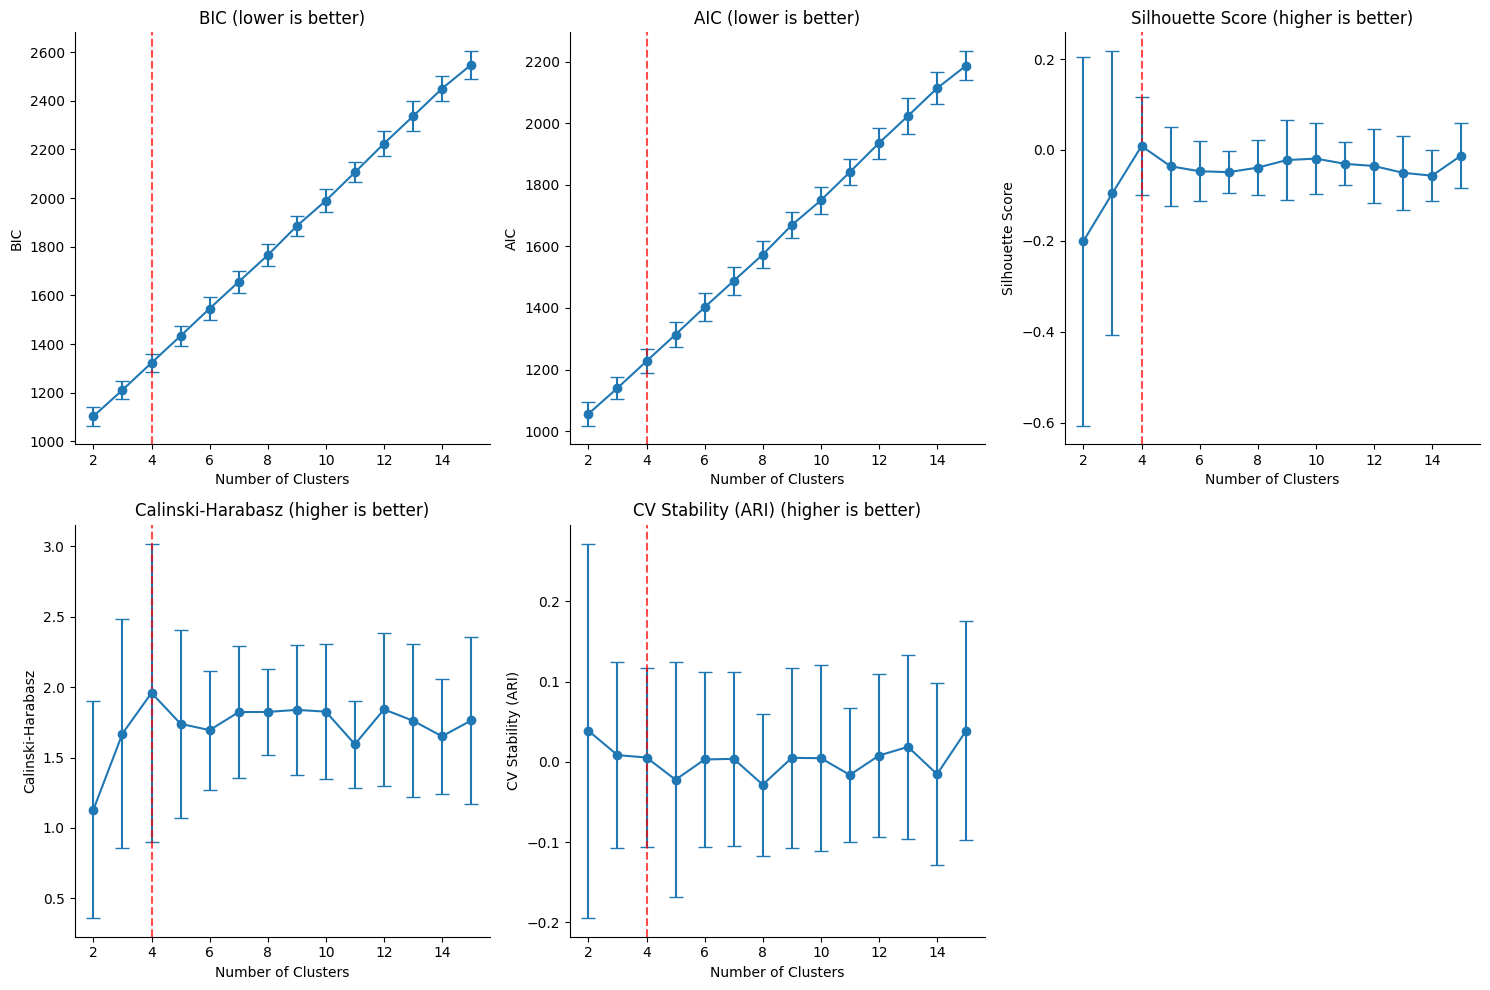

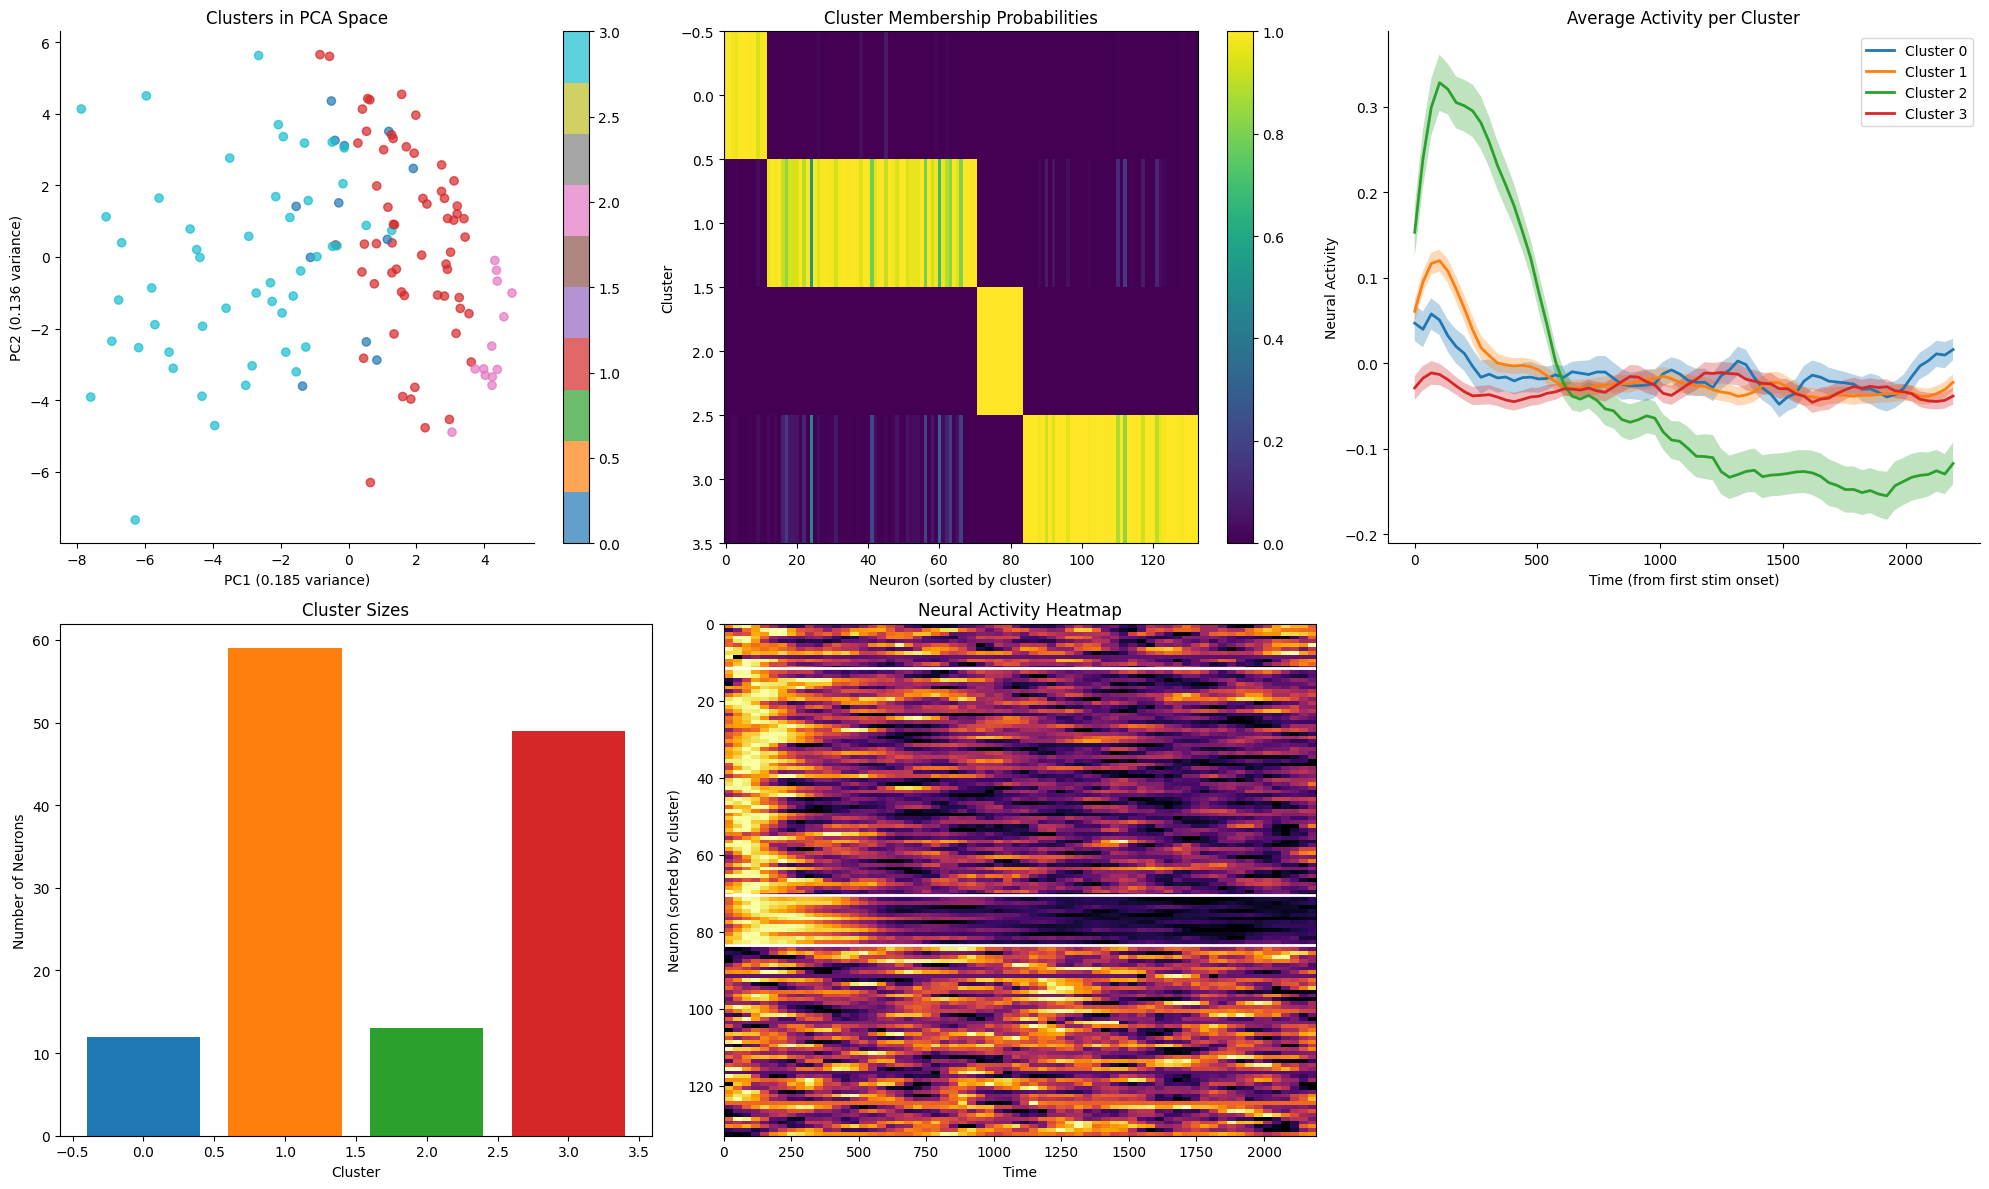

In [51]:
from Modules.Alignment import get_perception_response
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import pandas as pd
from scipy import stats
import os
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

class NeuralActivityClustering:
    def __init__(self, neural_data, random_state=42):
        """
        Initialize clustering analysis for neural activity data
        
        Parameters:
        neural_data: numpy array of shape (n_neurons, time_points)
                    Average neural activity from first stim onset to second stim onset
        """
        self.neural_data = neural_data
        self.n_neurons, self.n_timepoints = neural_data.shape
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.pca = None
        self.best_gmm = None
        self.cluster_labels = None
        self.cv_results = {}
        
    def preprocess_data(self, apply_pca=True, n_components=0.95):
        """
        Preprocess neural activity data with z-score normalization and optional PCA
        
        Parameters:
        apply_pca: bool, whether to apply PCA for dimensionality reduction
        n_components: float or int, number of components to keep (if float, variance explained)
        """
        print("Preprocessing neural activity data...")
        
        # Z-score normalization across time for each neuron
        self.data_normalized = self.scaler.fit_transform(self.neural_data.T).T
        
        if apply_pca:
            self.pca = PCA(n_components=n_components, random_state=self.random_state)
            self.data_processed = self.pca.fit_transform(self.data_normalized)
            print(f"PCA applied: {self.data_processed.shape[1]} components explain "
                  f"{self.pca.explained_variance_ratio_.sum():.3f} of variance")
        else:
            self.data_processed = self.data_normalized
            
        return self.data_processed
    
    def find_optimal_clusters(self, max_clusters=15, cv_folds=5):
        """
        Find optimal number of clusters using cross-validation and multiple metrics
        
        Parameters:
        max_clusters: int, maximum number of clusters to test
        cv_folds: int, number of cross-validation folds
        """
        print(f"Finding optimal number of clusters (max={max_clusters})...")
        
        n_clusters_range = range(2, max_clusters + 1)
        
        # Initialize result storage
        results = {
            'n_clusters': [],
            'bic_mean': [], 'bic_std': [],
            'aic_mean': [], 'aic_std': [],
            'silhouette_mean': [], 'silhouette_std': [],
            'calinski_harabasz_mean': [], 'calinski_harabasz_std': [],
            'cv_stability_mean': [], 'cv_stability_std': []
        }
        
        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        for n_clusters in n_clusters_range:
            # print(f"Testing {n_clusters} clusters...")
            
            fold_bic, fold_aic, fold_silhouette, fold_calinski = [], [], [], []
            fold_labels = []
            
            # Cross-validation
            for fold, (train_idx, val_idx) in enumerate(kf.split(self.data_processed)):
                # Fit GMM on training data
                gmm = GaussianMixture(
                    n_components=n_clusters,
                    covariance_type='diag',  # Changed from 'full' to 'diag'
                    reg_covar=1e-6,          # Added regularization
                    random_state=self.random_state + fold,
                    max_iter=200,
                    n_init=5                 # Multiple initializations
                )
                gmm.fit(self.data_processed[train_idx])
                
                # Predict on validation data
                val_labels = gmm.predict(self.data_processed[val_idx])
                fold_labels.append(val_labels)
                
                # Calculate metrics on validation set
                fold_bic.append(gmm.bic(self.data_processed[val_idx]))
                fold_aic.append(gmm.aic(self.data_processed[val_idx]))
                
                if len(np.unique(val_labels)) > 1:  # Check if more than one cluster
                    fold_silhouette.append(silhouette_score(self.data_processed[val_idx], val_labels))
                    fold_calinski.append(calinski_harabasz_score(self.data_processed[val_idx], val_labels))
                else:
                    fold_silhouette.append(-1)  # Invalid score
                    fold_calinski.append(0)
            
            # Calculate stability across folds (using ARI between fold pairs)
            stability_scores = []
            for i in range(len(fold_labels)):
                for j in range(i+1, len(fold_labels)):
                    if len(fold_labels[i]) == len(fold_labels[j]):
                        stability_scores.append(adjusted_rand_score(fold_labels[i], fold_labels[j]))
            
            # Store results
            results['n_clusters'].append(n_clusters)
            results['bic_mean'].append(np.mean(fold_bic))
            results['bic_std'].append(np.std(fold_bic))
            results['aic_mean'].append(np.mean(fold_aic))
            results['aic_std'].append(np.std(fold_aic))
            results['silhouette_mean'].append(np.mean(fold_silhouette))
            results['silhouette_std'].append(np.std(fold_silhouette))
            results['calinski_harabasz_mean'].append(np.mean(fold_calinski))
            results['calinski_harabasz_std'].append(np.std(fold_calinski))
            results['cv_stability_mean'].append(np.mean(stability_scores) if stability_scores else 0)
            results['cv_stability_std'].append(np.std(stability_scores) if stability_scores else 0)
        
        self.cv_results = pd.DataFrame(results)
        
        # Find optimal number of clusters
        # Combine multiple criteria (lower BIC/AIC, higher silhouette/calinski/stability)
        normalized_bic = (np.max(results['bic_mean']) - np.array(results['bic_mean'])) / \
                        (np.max(results['bic_mean']) - np.min(results['bic_mean']))
        normalized_aic = (np.max(results['aic_mean']) - np.array(results['aic_mean'])) / \
                        (np.max(results['aic_mean']) - np.min(results['aic_mean']))
        normalized_silhouette = (np.array(results['silhouette_mean']) - np.min(results['silhouette_mean'])) / \
                               (np.max(results['silhouette_mean']) - np.min(results['silhouette_mean']))
        normalized_stability = (np.array(results['cv_stability_mean']) - np.min(results['cv_stability_mean'])) / \
                              (np.max(results['cv_stability_mean']) - np.min(results['cv_stability_mean']))
        
        # Composite score (equal weights)
        composite_score = (normalized_bic + normalized_aic + normalized_silhouette + normalized_stability) / 4
        self.optimal_n_clusters = n_clusters_range[np.argmax(composite_score)]
        
        print(f"Optimal number of clusters: {self.optimal_n_clusters}")
        return self.optimal_n_clusters
    
    def fit_final_model(self, n_clusters=None):
        """
        Fit final GMM model with optimal number of clusters
        
        Parameters:
        n_clusters: int, number of clusters (if None, uses optimal from CV)
        """
        if n_clusters is None:
            n_clusters = self.optimal_n_clusters
            
        print(f"Fitting final GMM model with {n_clusters} clusters...")
        
        self.best_gmm = GaussianMixture(
            n_components=n_clusters,
            covariance_type='diag',  # Changed from 'full' to 'diag'
            reg_covar=1e-6,          # Added regularization
            random_state=self.random_state,
            max_iter=200,
            n_init=10                # Multiple initializations
        )
        
        self.best_gmm.fit(self.data_processed)
        self.cluster_labels = self.best_gmm.predict(self.data_processed)
        self.cluster_probabilities = self.best_gmm.predict_proba(self.data_processed)
        
        # Calculate final metrics
        self.final_metrics = {
            'bic': self.best_gmm.bic(self.data_processed),
            'aic': self.best_gmm.aic(self.data_processed),
            'silhouette': silhouette_score(self.data_processed, self.cluster_labels),
            'calinski_harabasz': calinski_harabasz_score(self.data_processed, self.cluster_labels),
            'log_likelihood': self.best_gmm.score(self.data_processed)
        }
        
        print("Final clustering metrics:")
        for metric, value in self.final_metrics.items():
            print(f"  {metric}: {value:.3f}")
            
        return self.cluster_labels
    
    def plot_cv_results(self, figsize=(15, 10), save_path=None):
        """Plot cross-validation results"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.ravel()
        
        metrics = [
            ('BIC', 'bic_mean', 'bic_std', 'lower is better'),
            ('AIC', 'aic_mean', 'aic_std', 'lower is better'),
            ('Silhouette Score', 'silhouette_mean', 'silhouette_std', 'higher is better'),
            ('Calinski-Harabasz', 'calinski_harabasz_mean', 'calinski_harabasz_std', 'higher is better'),
            ('CV Stability (ARI)', 'cv_stability_mean', 'cv_stability_std', 'higher is better')
        ]
        
        for i, (title, mean_col, std_col, direction) in enumerate(metrics):
            axes[i].errorbar(self.cv_results['n_clusters'], 
                           self.cv_results[mean_col], 
                           yerr=self.cv_results[std_col],
                           marker='o', capsize=5)
            axes[i].axvline(x=self.optimal_n_clusters, color='red', linestyle='--', alpha=0.7)
            axes[i].set_xlabel('Number of Clusters')
            axes[i].set_ylabel(title)
            axes[i].set_title(f'{title} ({direction})')
            # axes[i].grid(True, alpha=0.3)
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
        
        # Remove the last subplot
        axes[-1].remove()
        
        plt.tight_layout()
        if save_path is not None:
            figures_dir = os.path.join(save_path, 'Figures')
            if not os.path.exists(figures_dir):
                os.makedirs(figures_dir)
            save_path = os.path.join(figures_dir, 'clustering_metrics.pdf')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_clustering_results(self, neu_time, n_neurons, figsize=(20, 12), save_path=None):

        def apply_colormap(data, cmap):
            """Normalize data and apply colormap."""
            if len(data) > 0:
                vmin, vmax = data.min(), data.max()
                normalized = (data - vmin) / (vmax - vmin + 1e-10)
                return cmap(normalized)
            return np.array([])

        """Plot clustering results and neural activity patterns"""
        n_clusters = len(np.unique(self.cluster_labels))

        fig = plt.figure(figsize=figsize)

        # 1. PCA visualization
        if self.pca is not None:
            ax1 = plt.subplot(2, 3, 1)
            scatter = ax1.scatter(self.data_processed[:, 0], self.data_processed[:, 1],
                                c=self.cluster_labels, cmap='tab10', alpha=0.7)
            ax1.set_xlabel(f'PC1 ({self.pca.explained_variance_ratio_[0]:.3f} variance)')
            ax1.set_ylabel(f'PC2 ({self.pca.explained_variance_ratio_[1]:.3f} variance)')
            ax1.set_title('Clusters in PCA Space')
            fig.colorbar(scatter, ax=ax1)
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)

        # 2. Cluster probability heatmap
        ax2 = plt.subplot(2, 3, 2)
        sorted_idx = np.argsort(self.cluster_labels)
        ax2.imshow(self.cluster_probabilities[sorted_idx].T, aspect='auto', cmap='viridis')
        ax2.set_xlabel('Neuron (sorted by cluster)')
        ax2.set_ylabel('Cluster')
        ax2.set_title('Cluster Membership Probabilities')
        plt.colorbar(ax2.images[0], ax=ax2)

        # 3. Average neural activity per cluster
        ax3 = plt.subplot(2, 3, 3)
        for cluster_id in range(n_clusters):
            cluster_neurons = self.cluster_labels == cluster_id
            mean_activity = np.mean(self.neural_data[cluster_neurons], axis=0)
            sem_activity = stats.sem(self.neural_data[cluster_neurons], axis=0)

            ax3.plot(neu_time, mean_activity, label=f'Cluster {cluster_id}', linewidth=2)
            ax3.fill_between(neu_time,
                            mean_activity - sem_activity,
                            mean_activity + sem_activity,
                            alpha=0.3)
        ax3.set_xlabel('Time (from first stim onset)')
        ax3.set_ylabel('Neural Activity')
        ax3.set_title('Average Activity per Cluster')
        ax3.legend()
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

        # 4. Cluster sizes
        ax4 = plt.subplot(2, 3, 4)
        cluster_counts = np.bincount(self.cluster_labels)
        ax4.bar(range(n_clusters), cluster_counts, color=plt.cm.tab10(np.arange(n_clusters)))
        ax4.set_xlabel('Cluster')
        ax4.set_ylabel('Number of Neurons')
        ax4.set_title('Cluster Sizes')

        # 5. Neural activity heatmap sorted by cluster
        ax5 = plt.subplot(2, 3, 5)
        sorted_data = self.neural_data[sorted_idx]
        cmap = cm.get_cmap('inferno')
        heatmap_rgb = np.array([apply_colormap(row, cmap) for row in sorted_data])
        im = ax5.imshow(heatmap_rgb, interpolation='nearest', aspect='auto',
                   extent=[neu_time[0], neu_time[-1], n_neurons, 0])
        ax5.set_xlabel('Time')
        ax5.set_ylabel('Neuron (sorted by cluster)')
        ax5.set_title('Neural Activity Heatmap')
        # plt.colorbar(im, ax=ax5)

        # Add cluster boundaries
        cluster_boundaries = np.cumsum(cluster_counts)[:-1]
        for boundary in cluster_boundaries:
            ax5.axhline(y=boundary - 0.5, color='white', linewidth=2)

        # Remove last (empty) subplot if figure has more slots than used
        # if len(fig.axes) > 5:
        #     fig.delaxes(fig.axes[-1])

        plt.tight_layout()
        plt.show()

        if save_path is not None:
            figures_dir = os.path.join(save_path, 'Figures')
            os.makedirs(figures_dir, exist_ok=True)
            fig_path = os.path.join(figures_dir, 'clustering_results.pdf')
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')


def main(neural_data, neu_time, save_path=None):
    
    # Initialize and run clustering
    clustering = NeuralActivityClustering(neural_data)
    
    # Preprocess data
    clustering.preprocess_data(apply_pca=True, n_components=0.95)
    
    # Find optimal number of clusters
    optimal_k = clustering.find_optimal_clusters(max_clusters=15, cv_folds=10)
    
    # Fit final model
    cluster_labels = clustering.fit_final_model()
    
    # Plot results
    clustering.plot_cv_results(save_path=save_path)
    n_neurons = neural_data.shape[0]
    clustering.plot_clustering_results(neu_time, n_neurons, save_path=save_path)

def pool_session_data(neural_trials_list, labels_list, state, l_frames, r_frames, indices):
    """
    Pool data from multiple sessions.
    
    Returns:
    tuple: Pooled neu_seq (n_trials_total, n_neurons_total, time), neu_time, trial_type, isi, decision, labels
    """
    neu_seqs = []
    trial_types = []
    isis = []
    decisions = []
    all_labels = []

    neuron_counts = [labels.shape[0] for labels in labels_list]
    total_neurons = sum(neuron_counts)

    neuron_offset = 0  # for assigning each session's neurons into the correct padded space

    for i, (neural_trials, session_labels) in enumerate(zip(neural_trials_list, labels_list)):
        neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = get_perception_response(
            neural_trials, state, l_frames, r_frames, indices=indices)

        n_trials, n_neurons, n_time = neu_seq.shape
        padded_neu_seq = np.zeros((n_trials, total_neurons, n_time))

        # Place this session’s neurons in the correct slice
        padded_neu_seq[:, neuron_offset:neuron_offset + n_neurons, :] = neu_seq
        neu_seqs.append(padded_neu_seq)

        trial_types.append(trial_type)
        isis.append(isi)
        decisions.append(decision)
        all_labels.append(session_labels)

        neuron_offset += n_neurons

    # Concatenate along trials
    pooled_neu_seq = np.concatenate(neu_seqs, axis=0)  # (total_trials, total_neurons, time)
    pooled_trial_type = np.concatenate(trial_types, axis=0)
    pooled_isi = np.concatenate(isis, axis=0)
    pooled_decision = np.concatenate(decisions, axis=0)
    pooled_labels = np.concatenate(all_labels, axis=0)

    return pooled_neu_seq, neu_time, pooled_trial_type, pooled_isi, pooled_decision, pooled_labels

def find_min_long_trial_isi(neural_trials):
    """
    Find the smallest ISI (inter-stimulus interval) among long trials (trial_type == 1).

    Parameters:
    neural_trials (dict or list of dict): Single session or list of sessions. 
        Each session should be a dict with key ['trial_labels'] containing keys 'trial_type' and 'isi'.

    Returns:
    float: Minimum ISI among long trials across all sessions.
    """
    min_time_interval = np.inf

    if isinstance(neural_trials, dict):
        # Single session
        long_trials = neural_trials['trial_labels']['trial_type'] == 1
        if np.any(long_trials):
            min_time_interval = np.min(neural_trials['trial_labels']['isi'][long_trials])
    elif isinstance(neural_trials, list):
        # Multiple sessions
        for session in neural_trials:
            long_trials = session['trial_labels']['trial_type'] == 1
            if np.any(long_trials):
                session_min = np.min(session['trial_labels']['isi'][long_trials])
                min_time_interval = min(min_time_interval, session_min)

    if np.isinf(min_time_interval):
        raise ValueError("No long trials (trial_type == 1) found in the provided data.")
    
    # turn it to the timepoint
    # fs = 30 hz
    min_time_interval_frame = int(np.floor(min_time_interval / 30))

    return min_time_interval, min_time_interval_frame

def get_avg_neural_activity(neu_seq, trial_type):
    """
    Compute average neural activity from first stim onset to second stim onset for each neuron,
    using only long trials (trial_type == 1).

    Parameters:
    neu_seq: np.ndarray, shape (n_trials, n_neurons, time)
    trial_type: np.ndarray, shape (n_trials,)

    Returns:
    avg_neuron: np.ndarray, shape (n_neurons, time)
    """
    long_trials = trial_type == 1
    avg_neuron = np.nanmean(neu_seq[long_trials], axis=0)  # Shape: (n_neurons, time)
    return avg_neuron
    
def clustering_GMM(neural_trials, labels, save_path = None, pooling = False):
    
    # get the framse for the smallest time interval among the long trials
    l_frames = 0
    _ , r_frames = find_min_long_trial_isi(neural_trials)
    if pooling:
        neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = pool_session_data(neural_trials, labels, 'stim_seq', l_frames, r_frames, indices=0)
    else:
        neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = get_perception_response(neural_trials, 'stim_seq', l_frames, r_frames, indices=0)

    # Average neural activity from first stim onset to second stim onset for each neuron
    neural_data = get_avg_neural_activity(neu_seq, trial_type)
    main(neural_data,neu_time, save_path = save_path)

clustering_GMM(neural_trials, labels, save_path = None, pooling = False)

# Decoding

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils import resample
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from Modules.Alignment import get_perception_response
import os


def neural_decoder_svm(data, labels, neu_time, trial_type, isi, shuffle = None, bin_data=False, bin_size=3, test_size=0.2, 
                      cv_folds= 5, C=0.1, undersample=True, random_state=42, save_path=None):
    """
    SVM decoder for 2AFC calcium imaging data with 4 labels.
    
    Parameters:
    -----------
    data : np.array
        Neural data with shape (n_trials, n_neurons, n_timepoints)
    labels : np.array
        Trial labels (0: short_left, 1: short_right, 2: long_left, 3: long_right)
    bin_data : bool
        Whether to bin the temporal data (default: False)
    bin_size : int
        Number of timepoints to bin together (default: 3)
    test_size : float
        Proportion of data for testing (default: 0.2)
    cv_folds : int
        Number of cross-validation folds (default: 5)
    C : float
        SVM regularization parameter (default: 1.0)
    undersample : bool
        Whether to randomly undersample majority classes (default: True)
    random_state : int
        Random seed for reproducibility (default: 42)
    
    Returns:
    --------
    results : dict
        Dictionary containing decoder results and metrics
    """
    
    np.random.seed(random_state)
    
    print("=== Neural Decoder Analysis ===")
    print(f"Original data shape: {data.shape}")
    
    # Step 1: Data preprocessing
    if bin_data:
        print(f"Binning data with bin size: {bin_size}")
        n_trials, n_neurons, n_timepoints = data.shape
        n_bins = n_timepoints // bin_size
        
        # Reshape and bin the data
        binned_data = data[:, :, :n_bins*bin_size].reshape(n_trials, n_neurons, n_bins, bin_size)
        data_processed = np.mean(binned_data, axis=3)  # Average within bins
        print(f"Binned data shape: {data_processed.shape}")
    else:
        print("Using unbinned data")
        data_processed = data.copy()
    
    # Step 2: Flatten the data (trials, neurons*timepoints)
    n_trials, n_neurons, n_timepoints = data_processed.shape
    X = data_processed.reshape(n_trials, n_neurons * n_timepoints)
    y = labels.copy()
    
    print(f"Flattened feature matrix shape: {X.shape}")
    
    # Step 3: Analyze label distribution
    label_names = ['short_left', 'short_right', 'long_left', 'long_right']
    label_counts = Counter(y)
    
    print("\n=== Label Distribution ===")
    for i, name in enumerate(label_names):
        count = label_counts.get(i, 0)
        print(f"{name}: {count} trials ({count/len(y)*100:.1f}%)")
    
    # Step 4: Handle class imbalance with undersampling
    if undersample and len(set(label_counts.values())) > 1:  # Only if imbalanced
        print("\n=== Undersampling Majority Classes ===")
        min_count = min(label_counts.values())
        print(f"Undersampling to {min_count} trials per class")
        
        # Combine data and labels for resampling
        indices_to_keep = []
        
        for label in range(4):
            label_indices = np.where(y == label)[0]
            if len(label_indices) > min_count:
                # Randomly sample min_count indices
                sampled_indices = np.random.choice(label_indices, min_count, replace=False)
                indices_to_keep.extend(sampled_indices)
            else:
                indices_to_keep.extend(label_indices)
        
        # Reorder and subset the data
        indices_to_keep = np.array(indices_to_keep)
        X = X[indices_to_keep]
        y = y[indices_to_keep]
        
        # Print new distribution
        new_label_counts = Counter(y)
        print("New label distribution:")
        for i, name in enumerate(label_names):
            count = new_label_counts.get(i, 0)
            print(f"{name}: {count} trials ({count/len(y)*100:.1f}%)")
    
    # Step 5: Train-test split with stratification
    print(f"\n=== Train-Test Split ({int((1-test_size)*100)}/{int(test_size*100)}) ===")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    print(f"Training set: {X_train.shape[0]} trials")
    print(f"Test set: {X_test.shape[0]} trials")
    
    # Step 6: Feature scaling
    print("\n=== Feature Scaling ===")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Applied z-score normalization")
    
    # Step 7: SVM with L2 regularization and balanced class weights
    print(f"\n=== SVM Training (C={C}) ===")
    svm_model = SVC(
        kernel='linear',
        C=C,  # L2 regularization (smaller C = more regularization)
        class_weight='balanced',  # Handle any remaining class imbalance
        random_state=random_state
    )
    
    # Step 8: Cross-validation on training set
    print(f"\n=== {cv_folds}-Fold Cross-Validation ===")
    cv_scores = cross_val_score(
        svm_model, X_train_scaled, y_train, 
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state),
        scoring='balanced_accuracy'
    )
    
    print(f"CV Balanced Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"CV Scores: {[f'{score:.3f}' for score in cv_scores]}")
    
    # Step 9: Train final model and evaluate on test set
    svm_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = svm_model.predict(X_train_scaled)
    y_test_pred = svm_model.predict(X_test_scaled)
    
    # Calculate metrics
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    
    print(f"\n=== Final Results ===")
    print(f"Training Balanced Accuracy: {train_balanced_acc:.3f}")
    print(f"Test Balanced Accuracy: {test_balanced_acc:.3f}")
    
    # Step 10: Detailed classification report
    print(f"\n=== Classification Report (Test Set) ===")
    target_names = [f'{i}_{name}' for i, name in enumerate(label_names)]
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    # save text of the report
    if save_path is not None:
        report_dir = os.path.join(save_path, 'Figures')
        os.makedirs(report_dir, exist_ok=True)
        shuffle_str = f"_{shuffle}" if shuffle is not None else ""
        report_path = os.path.join(report_dir, f'decoder_classification_report{shuffle_str}.txt')
        with open(report_path, 'w') as f:
            f.write(classification_report(y_test, y_test_pred, target_names=target_names))
    
    # Step 11: Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    if save_path is not None:
        figures_dir = os.path.join(save_path, 'Figures')
        os.makedirs(figures_dir, exist_ok=True)
        # Add shuffle info to filename if present
        shuffle_str = f"_{shuffle}" if shuffle is not None else ""
        fig_path = os.path.join(figures_dir, f'Confusion Matrix{shuffle_str}.pdf')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    # plt.show()
    
    # Step 12: Feature importance (SVM weights)
    feature_weights = svm_model.coef_
    print(f"\nSVM decision function weights shape: {feature_weights.shape}")
    
    # For multiclass SVM, we get one weight vector per class comparison
    # Average absolute weights across all comparisons
    avg_weights = np.mean(np.abs(feature_weights), axis=0)
    
    # Reshape back to (neurons, timepoints) for visualization
    if bin_data:
        weight_matrix = avg_weights.reshape(n_neurons, n_bins)
        time_label = f'Time Bins (bin_size={bin_size})'
    else:
        weight_matrix = avg_weights.reshape(n_neurons, n_timepoints)
        time_label = 'Time Points'
    
    
    # Plot heatmap with neu_time as x-axis labels (if shape matches)
    if weight_matrix.shape[1] == len(neu_time):
        # Create a figure with subplots: heatmap on top, distributions below
        fig = plt.figure(figsize=(10, 8))

        # Create custom grid layout to control colorbar placement
        gs = fig.add_gridspec(2, 2, height_ratios=[5, 1], width_ratios=[20, 1], 
                            hspace=0.1, wspace=0.05)

        ax_heatmap = fig.add_subplot(gs[0, 0])
        ax_cbar = fig.add_subplot(gs[0, 1])
        ax_dist = fig.add_subplot(gs[1, 0])

        # Plot heatmap
        im = ax_heatmap.imshow(weight_matrix, cmap='inferno', aspect='auto', 
                            extent=[neu_time[0], neu_time[-1], 0, weight_matrix.shape[0]])

        # Add colorbar in dedicated subplot
        cbar = plt.colorbar(im, cax=ax_cbar)
        cbar.set_label('Average |Weight|', rotation=270, labelpad=20)

        # Set heatmap labels and ticks
        ax_heatmap.set_ylabel('Neuron/Channel')
        ax_heatmap.set_xticks(np.linspace(neu_time[0], neu_time[-1], 10))
        ax_heatmap.set_xticklabels(np.round(np.linspace(neu_time[0], neu_time[-1], 10), 1), 
                                rotation=45)

        # Add vertical line at time zero in heatmap
        ax_heatmap.axvline(x=0, color='white', linestyle='--', linewidth=2)
        ax_heatmap.set_title('SVM Feature Importance Heatmap')

        # Plot ISI distributions without artificial scaling
        sns.kdeplot(x=isi[trial_type == 0] + 200, label='Short', color='blue', 
                    ax=ax_dist, bw_adjust=1.5)
        sns.kdeplot(x=isi[trial_type == 1] + 200, label='long', color='red', 
                    ax=ax_dist, bw_adjust=1.5)

        # Customize distribution plot
        ax_dist.set_xlabel('Time')
        ax_dist.set_ylabel('Density')
        ax_dist.spines['top'].set_visible(False)
        ax_dist.spines['right'].set_visible(False)
        ax_dist.legend()

        # Match x-axis limits
        ax_dist.set_xlim(neu_time[0], neu_time[-1])

        # Remove x-axis labels from heatmap since they're shared
        ax_heatmap.set_xticklabels([])
        # plt.tight_layout()
    else:
        plt.figure(figsize=(12, 6))
        sns.heatmap(weight_matrix, cmap='inferno', cbar_kws={'label': 'Average |Weight|'})
        plt.title('SVM Feature Importance Heatmap')
        plt.xlabel(time_label)
        plt.ylabel('Neurons')
        plt.tight_layout()

    if save_path is not None:
        figures_dir = os.path.join(save_path, 'Figures')
        os.makedirs(figures_dir, exist_ok=True)
        # Add shuffle info to filename if present
        shuffle_str = f"_{shuffle}" if shuffle is not None else ""
        fig_path = os.path.join(figures_dir, f'SVM_Feature_Importance_Heatmap{shuffle_str}.pdf')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        plt.close()
    plt.close()
    
    # Step 13: Compile results
    results = {
        'model': svm_model,
        'scaler': scaler,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_balanced_accuracy': train_balanced_acc,
        'test_balanced_accuracy': test_balanced_acc,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'confusion_matrix': cm,
        'feature_weights': feature_weights,
        'weight_matrix': weight_matrix,
        'X_train_shape': X_train.shape,
        'X_test_shape': X_test.shape,
        'final_label_counts': Counter(y),
        'parameters': {
            'bin_data': bin_data,
            'bin_size': bin_size,
            'C': C,
            'cv_folds': cv_folds,
            'test_size': test_size,
            'undersample': undersample,
            'random_state': random_state
        }
    }
    
    return results

def pool_session_data(neural_trials_list, labels_list, state, l_frames, r_frames, indices):
    """
    Pool data from multiple sessions.
    
    Returns:
    tuple: Pooled neu_seq (n_trials_total, n_neurons_total, time), neu_time, trial_type, isi, decision, labels
    """
    neu_seqs = []
    trial_types = []
    isis = []
    decisions = []
    all_labels = []

    neuron_counts = [labels.shape[0] for labels in labels_list]
    total_neurons = sum(neuron_counts)

    neuron_offset = 0  # for assigning each session's neurons into the correct padded space

    for i, (neural_trials, session_labels) in enumerate(zip(neural_trials_list, labels_list)):
        neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = get_perception_response(
            neural_trials, state, l_frames, r_frames, indices=indices)

        n_trials, n_neurons, n_time = neu_seq.shape
        padded_neu_seq = np.zeros((n_trials, total_neurons, n_time))

        # Place this session’s neurons in the correct slice
        padded_neu_seq[:, neuron_offset:neuron_offset + n_neurons, :] = neu_seq
        neu_seqs.append(padded_neu_seq)

        trial_types.append(trial_type)
        isis.append(isi)
        decisions.append(decision)
        all_labels.append(session_labels)

        neuron_offset += n_neurons

    # Concatenate along trials
    pooled_neu_seq = np.concatenate(neu_seqs, axis=0)  # (total_trials, total_neurons, time)
    pooled_trial_type = np.concatenate(trial_types, axis=0)
    pooled_isi = np.concatenate(isis, axis=0)
    pooled_decision = np.concatenate(decisions, axis=0)
    pooled_labels = np.concatenate(all_labels, axis=0)

    return pooled_neu_seq, neu_time, pooled_trial_type, pooled_isi, pooled_decision, pooled_labels

def plot_shuffle_vs_normal(results, results_shuffled, neu_time, isi, trial_type, save_path=None):
    """
    Plot comparison of average SVM feature weights (across neurons) for normal and shuffled labels,
    and show ISI distributions below. Add a vertical line at time zero.
    """

    # Average across neurons
    mean_weights = np.mean(results['weight_matrix'], axis=0)
    mean_weights_shuffled = np.mean(results_shuffled['weight_matrix'], axis=0)

    # Create figure with two subplots: weights and ISI distributions
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

    # Plot average weights
    ax1.plot(neu_time, mean_weights, label='Normal', color='black')
    ax1.plot(neu_time, mean_weights_shuffled, label='Shuffled', color='gray', linestyle='--')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Stim1 onset')
    ax1.set_ylabel('Mean |Weight| (across neurons)')
    ax1.set_title('SVM Feature Importance: Normal vs Shuffled')
    ax1.legend()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # ISI distributions
    if isi is not None and trial_type is not None:
        # Plot ISI distributions for short and long
        sns.kdeplot(x=isi[trial_type == 0] + 200, label='Short', color='blue', ax=ax2, bw_adjust=1.5)
        sns.kdeplot(x=isi[trial_type == 1] + 200, label='Long', color='red', ax=ax2, bw_adjust=1.5)
        ax2.legend()
    ax2.set_xlabel('Time')
    ax2.set_ylabel('ISI Density')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    if save_path is not None:
        figures_dir = os.path.join(save_path, 'Figures')
        os.makedirs(figures_dir, exist_ok=True)
        fig_path = os.path.join(figures_dir, f'average_weights.pdf')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        plt.close()
    plt.close()

def decoder_decision(neural_trials, labels, l_frames = 60, r_frames = 120, save_path=None, pooling=False):

    if pooling:
        neu_seq, neu_time, trial_type, isi, decision, labels = pool_session_data(neural_trials, labels, 'stim_seq', l_frames, r_frames, indices=0)
    else:
        neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = get_perception_response(neural_trials, 'stim_seq', l_frames, r_frames, indices=0)

    # trial_type: 0 for short, 1 for long
    # decision: 0 for left, 1 for right
    labels_decoder = trial_type * 2 + decision

    # Run decoder without binning
    results_unbinned = neural_decoder_svm(neu_seq, labels_decoder, neu_time, trial_type, isi, bin_data=False, save_path=save_path)


    print('Shuffle labels')
    # shuffle labels
    labels_decoder = np.random.permutation(labels_decoder)
    results_unbinned_shuffled = neural_decoder_svm(neu_seq, labels_decoder, neu_time, trial_type, isi, shuffle = 'shuffle', bin_data=False, save_path=save_path)

    # Run decoder with binning (every 3 timepoints)
    # results_binned = neural_decoder_svm(neu_seq, labels_decoder, neu_time, bin_data=True, bin_size=3)

    plot_shuffle_vs_normal(results_unbinned, results_unbinned_shuffled, neu_time, isi, trial_type, save_path=save_path)

    # Access results
    print(f"Best CV accuracy: {results_unbinned['cv_mean']:.3f}")
    # print(f"Test accuracy: {results_unbinned['test_balanced_accuracy']:.3f}")
decoder_decision(neural_trials, labels, l_frames = 60, r_frames = 120, save_path=list_session_data_path[0], pooling=False)

=== Neural Decoder Analysis ===
Original data shape: (398, 133, 180)
Using unbinned data
Flattened feature matrix shape: (398, 23940)

=== Label Distribution ===
short_left: 138 trials (34.7%)
short_right: 57 trials (14.3%)
long_left: 60 trials (15.1%)
long_right: 143 trials (35.9%)

=== Undersampling Majority Classes ===
Undersampling to 57 trials per class
New label distribution:
short_left: 57 trials (25.0%)
short_right: 57 trials (25.0%)
long_left: 57 trials (25.0%)
long_right: 57 trials (25.0%)

=== Train-Test Split (80/20) ===
Training set: 182 trials
Test set: 46 trials

=== Feature Scaling ===
Applied z-score normalization

=== SVM Training (C=0.1) ===

=== 5-Fold Cross-Validation ===
CV Balanced Accuracy: 0.973 ± 0.001
CV Scores: ['0.975', '0.972', '0.972', '0.972', '0.972']

=== Final Results ===
Training Balanced Accuracy: 1.000
Test Balanced Accuracy: 1.000

=== Classification Report (Test Set) ===
               precision    recall  f1-score   support

 0_short_left       

# Temporal decoder analysis


100%|██████████| 402/402 [00:00<00:00, 4322.75it/s]



=== Running Temporal Decoding Analysis ===
=== Temporal Decoding Accuracy Analysis ===
Data shape: (398, 133, 180)
Window size: 10, Step size: 5
Number of bootstrap iterations: 10
Number of time windows: 35
Processing window 1/35: t=-1855.2s (indices 0-10)
Processing window 2/35: t=-1686.5s (indices 5-15)
Processing window 3/35: t=-1517.8s (indices 10-20)
Processing window 4/35: t=-1349.2s (indices 15-25)
Processing window 5/35: t=-1180.5s (indices 20-30)
Processing window 6/35: t=-1011.9s (indices 25-35)
Processing window 7/35: t=-843.2s (indices 30-40)
Processing window 8/35: t=-674.6s (indices 35-45)
Processing window 9/35: t=-506.0s (indices 40-50)
Processing window 10/35: t=-337.3s (indices 45-55)
Processing window 11/35: t=-168.6s (indices 50-60)
Processing window 12/35: t=0.0s (indices 55-65)
Processing window 13/35: t=168.7s (indices 60-70)
Processing window 14/35: t=337.3s (indices 65-75)
Processing window 15/35: t=506.0s (indices 70-80)
Processing window 16/35: t=674.6s (ind

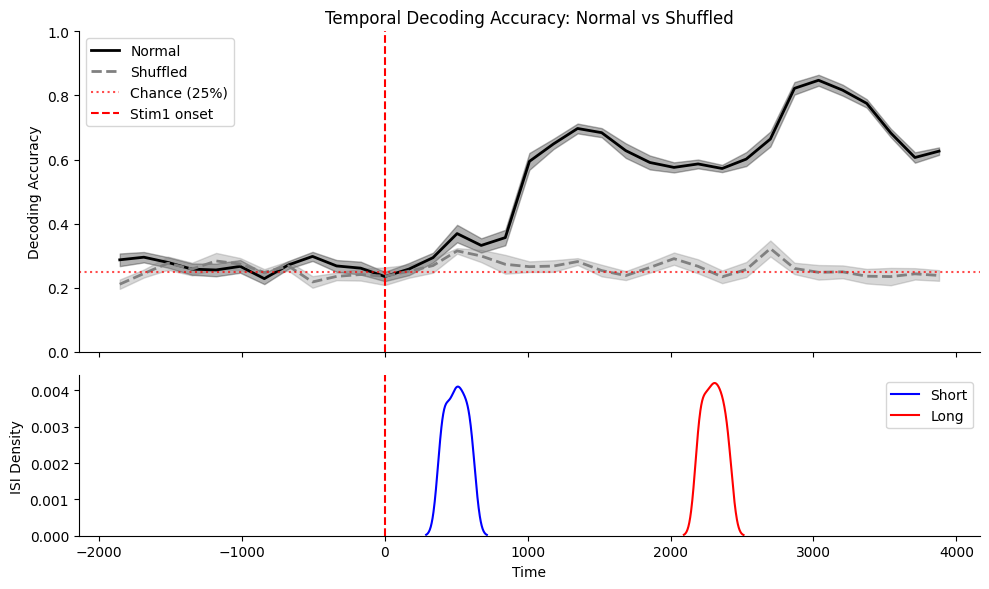

Peak temporal decoding accuracy: 0.847


{'window_times': array([-1855.1523 , -1686.4982 , -1517.8478 , -1349.1978 , -1180.5457 ,
        -1011.8937 ,  -843.2473 ,  -674.5924 ,  -505.95023,  -337.29553,
         -168.64828,     0.     ,   168.65598,   337.30896,   505.9576 ,
          674.60834,   843.2604 ,  1011.90594,  1180.5619 ,  1349.2139 ,
         1517.8624 ,  1686.5121 ,  1855.1632 ,  2023.8151 ,  2192.4639 ,
         2361.1184 ,  2529.7622 ,  2698.4197 ,  2867.0645 ,  3035.7214 ,
         3204.3655 ,  3373.0144 ,  3541.6714 ,  3710.3242 ,  3878.9744 ],
       dtype=float32),
 'mean_acc_normal': array([0.28731061, 0.29545455, 0.27916667, 0.25814394, 0.25568182,
        0.26685606, 0.22859848, 0.27140152, 0.29791667, 0.26818182,
        0.26136364, 0.23522727, 0.25833333, 0.29412879, 0.36912879,
        0.33219697, 0.35662879, 0.59431818, 0.64886364, 0.6969697 ,
        0.68390152, 0.62784091, 0.59090909, 0.57556818, 0.58636364,
        0.57215909, 0.60151515, 0.66401515, 0.82215909, 0.84734848,
        0.81647727, 0.

In [ ]:
def temporal_decoding_accuracy(data, labels, neu_time, trial_type, isi, window_size=10, 
                               step_size=5, n_iterations=10, test_size=0.2, C=0.1, 
                               undersample=True, random_state=42, save_path=None):
    """
    Analyze decoding accuracy as a function of time using sliding windows.
    
    Parameters:
    -----------
    data : np.array
        Neural data with shape (n_trials, n_neurons, n_timepoints)
    labels : np.array
        Trial labels (0: short_left, 1: short_right, 2: long_left, 3: long_right)
    neu_time : np.array
        Time points corresponding to neural data
    window_size : int
        Size of sliding window in time points (default: 10)
    step_size : int
        Step size for sliding window (default: 5)
    n_iterations : int
        Number of iterations for bootstrap resampling (default: 10)
    test_size : float
        Proportion of data for testing (default: 0.2)
    C : float
        SVM regularization parameter (default: 0.1)
    undersample : bool
        Whether to randomly undersample majority classes (default: True)
    random_state : int
        Random seed for reproducibility (default: 42)
    save_path : str
        Path to save results (default: None)
    
    Returns:
    --------
    results : dict
        Dictionary containing temporal decoding results
    """
    
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import balanced_accuracy_score
    from collections import Counter
    import numpy as np
    
    print("=== Temporal Decoding Accuracy Analysis ===")
    print(f"Data shape: {data.shape}")
    print(f"Window size: {window_size}, Step size: {step_size}")
    print(f"Number of bootstrap iterations: {n_iterations}")
    
    n_trials, n_neurons, n_timepoints = data.shape
    
    # Generate sliding window positions
    window_starts = np.arange(0, n_timepoints - window_size + 1, step_size)
    window_centers = window_starts + window_size // 2
    window_times = neu_time[window_centers]
    
    print(f"Number of time windows: {len(window_starts)}")
    
    # Initialize results storage
    accuracies_normal = []
    accuracies_shuffled = []
    
    # Process each time window
    for i, start_idx in enumerate(window_starts):
        end_idx = start_idx + window_size
        window_time = neu_time[window_centers[i]]
        
        print(f"Processing window {i+1}/{len(window_starts)}: "
              f"t={window_time:.1f}s (indices {start_idx}-{end_idx})")
        
        # Extract data for current window
        window_data = data[:, :, start_idx:end_idx]
        
        # Flatten window data (trials, neurons*timepoints_in_window)
        X_window = window_data.reshape(n_trials, n_neurons * window_size)
        
        # Bootstrap iterations for this window
        window_acc_normal = []
        window_acc_shuffled = []
        
        for iteration in range(n_iterations):
            # Set seed for reproducibility within each iteration
            iteration_seed = random_state + iteration
            np.random.seed(iteration_seed)
            
            # Handle class imbalance with undersampling
            y_balanced = labels.copy()
            X_balanced = X_window.copy()
            
            if undersample:
                label_counts = Counter(y_balanced)
                if len(set(label_counts.values())) > 1:  # Only if imbalanced
                    min_count = min(label_counts.values())
                    indices_to_keep = []
                    
                    for label in range(4):
                        label_indices = np.where(y_balanced == label)[0]
                        if len(label_indices) > min_count:
                            sampled_indices = np.random.choice(label_indices, min_count, replace=False)
                            indices_to_keep.extend(sampled_indices)
                        else:
                            indices_to_keep.extend(label_indices)
                    
                    indices_to_keep = np.array(indices_to_keep)
                    X_balanced = X_balanced[indices_to_keep]
                    y_balanced = y_balanced[indices_to_keep]
            
            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X_balanced, y_balanced, test_size=test_size, 
                stratify=y_balanced, random_state=iteration_seed
            )
            
            # Feature scaling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train SVM - Normal labels
            svm_model = SVC(kernel='linear', C=C, class_weight='balanced', 
                          random_state=iteration_seed)
            svm_model.fit(X_train_scaled, y_train)
            y_pred_normal = svm_model.predict(X_test_scaled)
            acc_normal = balanced_accuracy_score(y_test, y_pred_normal)
            window_acc_normal.append(acc_normal)
            
            # Train SVM - Shuffled labels
            y_train_shuffled = np.random.permutation(y_train)
            svm_model_shuffled = SVC(kernel='linear', C=C, class_weight='balanced', 
                                   random_state=iteration_seed)
            svm_model_shuffled.fit(X_train_scaled, y_train_shuffled)
            y_pred_shuffled = svm_model_shuffled.predict(X_test_scaled)
            acc_shuffled = balanced_accuracy_score(y_test, y_pred_shuffled)
            window_acc_shuffled.append(acc_shuffled)
        
        # Store results for this window
        accuracies_normal.append(window_acc_normal)
        accuracies_shuffled.append(window_acc_shuffled)
    
    # Convert to numpy arrays for easier manipulation
    accuracies_normal = np.array(accuracies_normal)  # (n_windows, n_iterations)
    accuracies_shuffled = np.array(accuracies_shuffled)
    
    # Calculate statistics
    mean_acc_normal = np.mean(accuracies_normal, axis=1)
    sem_acc_normal = np.std(accuracies_normal, axis=1) / np.sqrt(n_iterations)
    mean_acc_shuffled = np.mean(accuracies_shuffled, axis=1)
    sem_acc_shuffled = np.std(accuracies_shuffled, axis=1) / np.sqrt(n_iterations)
    
    results = {
        'window_times': window_times,
        'mean_acc_normal': mean_acc_normal,
        'sem_acc_normal': sem_acc_normal,
        'mean_acc_shuffled': mean_acc_shuffled,
        'sem_acc_shuffled': sem_acc_shuffled,
        'all_acc_normal': accuracies_normal,
        'all_acc_shuffled': accuracies_shuffled,
        'parameters': {
            'window_size': window_size,
            'step_size': step_size,
            'n_iterations': n_iterations,
            'test_size': test_size,
            'C': C,
            'undersample': undersample,
            'random_state': random_state
        }
    }
    
    return results

def plot_temporal_decoding_accuracy(results, isi, trial_type, save_path=None):
    """
    Plot temporal decoding accuracy with error bars and ISI distributions.
    
    Parameters:
    -----------
    results : dict
        Results from temporal_decoding_accuracy function
    isi : np.array
        Inter-stimulus intervals
    trial_type : np.array
        Trial types (0: short, 1: long)
    save_path : str
        Path to save the figure (default: None)
    """
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), 
                                   gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    
    # Plot temporal decoding accuracy
    window_times = results['window_times']
    mean_acc_normal = results['mean_acc_normal']
    sem_acc_normal = results['sem_acc_normal']
    mean_acc_shuffled = results['mean_acc_shuffled']
    sem_acc_shuffled = results['sem_acc_shuffled']
    
    # Plot normal accuracy with error bars
    ax1.plot(window_times, mean_acc_normal, label='Normal', color='black', linewidth=2)
    ax1.fill_between(window_times, 
                     mean_acc_normal - sem_acc_normal,
                     mean_acc_normal + sem_acc_normal,
                     alpha=0.3, color='black')
    
    # Plot shuffled accuracy with error bars
    ax1.plot(window_times, mean_acc_shuffled, label='Shuffled', color='gray', 
             linestyle='--', linewidth=2)
    ax1.fill_between(window_times,
                     mean_acc_shuffled - sem_acc_shuffled,
                     mean_acc_shuffled + sem_acc_shuffled,
                     alpha=0.3, color='gray')
    
    # Add chance level line (25% for 4-class classification)
    ax1.axhline(y=0.25, color='red', linestyle=':', alpha=0.7, label='Chance (25%)')
    
    # Add vertical line at time zero
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Stim1 onset')
    
    ax1.set_ylabel('Decoding Accuracy')
    ax1.set_title('Temporal Decoding Accuracy: Normal vs Shuffled')
    ax1.legend()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim(0, 1)
    
    # Plot ISI distributions
    if isi is not None and trial_type is not None:
        sns.kdeplot(x=isi[trial_type == 0] + 200, label='Short', color='blue', 
                   ax=ax2, bw_adjust=1.5)
        sns.kdeplot(x=isi[trial_type == 1] + 200, label='Long', color='red', 
                   ax=ax2, bw_adjust=1.5)
        ax2.legend()
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('ISI Density')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    if save_path is not None:
        figures_dir = os.path.join(save_path, 'Figures')
        os.makedirs(figures_dir, exist_ok=True)
        fig_path = os.path.join(figures_dir, 'temporal_decoding_accuracy.pdf')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        plt.close()
    plt.close()

# Example usage in your decoder_decision function:
def decoder_decision_with_temporal_analysis(neural_trials, labels, l_frames=60, r_frames=120, 
                                           save_path=None, pooling=False):
    """
    Modified decoder_decision function that includes temporal decoding analysis.
    """
    
    if pooling:
        neu_seq, neu_time, trial_type, isi, decision, labels = pool_session_data(
            neural_trials, labels, 'stim_seq', l_frames, r_frames, indices=0)
    else:
        neu_seq, neu_time, stim_seq, stim_value, stim_time, led_value, trial_type, isi, decision, outcome = get_perception_response(
            neural_trials, 'stim_seq', l_frames, r_frames, indices=0)

    # trial_type: 0 for short, 1 for long
    # decision: 0 for left, 1 for right
    labels_decoder = trial_type * 2 + decision

    # Run original decoder analysis
    results_unbinned = neural_decoder_svm(neu_seq, labels_decoder, neu_time, trial_type, isi, 
                                        bin_data=False, save_path=save_path)

    # # Shuffle labels analysis
    labels_decoder_shuffle = np.random.permutation(labels_decoder)
    results_unbinned_shuffled = neural_decoder_svm(neu_seq, labels_decoder_shuffle, neu_time, 
                                                 trial_type, isi, shuffle='shuffle', 
                                                 bin_data=False, save_path=save_path)

    plot_shuffle_vs_normal(results_unbinned, results_unbinned_shuffled, neu_time, isi, 
                          trial_type, save_path=save_path)

    # NEW: Temporal decoding analysis
    print("\n=== Running Temporal Decoding Analysis ===")
    temporal_results = temporal_decoding_accuracy(neu_seq, labels_decoder, neu_time, 
                                                trial_type, isi, save_path=save_path)
    
    plot_temporal_decoding_accuracy(temporal_results, isi, trial_type, save_path=save_path)

    # Access results
    # print(f"Best CV accuracy: {results_unbinned['cv_mean']:.3f}")
    # print(f"Peak temporal decoding accuracy: {np.max(temporal_results['mean_acc_normal']):.3f}")
    
    return temporal_results

decoder_decision_with_temporal_analysis(neural_trials, labels, l_frames=60, r_frames=120, 
                                           save_path=None, pooling=False)